<a href="https://colab.research.google.com/github/arielgraham/Bandung-House-Price/blob/main/Property_Bandung.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [317]:
import re
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data Cleaning

In [318]:
df = pd.read_csv('results.csv',header=None)

# Define columns
df.columns = ('type', 'status', 'price', 'loan_scheme', 'house_name', 'location',
              'bedroom_count', 'bathroom_count', 'carport_count', 'land_area', 'building_area')

In [319]:
df.head(3)

type   status          price                   loan_scheme  \
0  Rumah  Premier  Rp 2,1 Miliar   Cicilan: 7 Jutaan per bulan   
1  Rumah      NaN  Rp 4,1 Miliar  Cicilan: 15 Jutaan per bulan   
2  Rumah      NaN  Rp 3,3 Miliar  Cicilan: 12 Jutaan per bulan   

                                          house_name        location  \
0  Rumah 2 Lantai Bagus Sertifikat Hak Milik di M...  Andir, Bandung   
1                    Rumah Cantik @ Andir (Sudirman)  Andir, Bandung   
2  Jual Cepat Rumah di Maleber Rajawali Bisa Untu...  Andir, Bandung   

   bedroom_count  bathroom_count  carport_count land_area building_area  
0              3               2              2    137 m²        170 m²  
1              3               2              3    202 m²        300 m²  
2              5               2              1    350 m²        258 m²

In [320]:
def clean_data(df):
  """
  Function to clean DataFrame in general,

  Parameters:
  - df: main DataFrame from csv with assigned columns

  This function returns a DataFrame, best use as is like common function
  """

  # Clean Loan Scheme (All in million rupiah per month)
  df['loan_scheme'] = df['loan_scheme'].apply(lambda x: float(x.split(' ')[1]))

  # Clean Location to Get Districts Only
  df['nama_kecamatan'] = df['location'].apply(lambda x: x.split(',')[0])
  df = df.drop('location',axis=1)

  # Clean area values (All in meter squared)
  df['land_area'] = df['land_area'].str.extract('(\d+)')
  df['land_area'] = pd.to_numeric(df['land_area'])

  df['building_area'] = df['building_area'].str.extract('(\d+)')
  df['building_area'] = pd.to_numeric(df['building_area'])

  return df

In [321]:
def clean_price(price):
    """
    Function to clean string on 'price' columns,
    this function best use with .apply(function)

    Parameters:
    - price: column contains price in rupiah, uniquely differ by Milliar or Juta

    This function might return an error if there is another string in one cell,
    the error is kept due to the nature of prices on the website tend to not involves any other string.
    Any string addition to the cell might not be a price of a house (apartment, land, warehouse, etc.)
    """

    # Remove 'Rp ' and replace comma with a dot
    price = price.replace('Rp ', '').replace(',', '.')

    # Convert 'Miliar' to billion (1 Miliar = 1,000,000,000)
    if 'Miliar' in price:
        return float(price.replace(' Miliar', '')) * 1_000_000_000
    # Convert 'Juta' to million (1 Juta = 1,000,000)
    elif 'Juta' in price:
        return float(price.replace(' Juta', '')) * 1_000_000
    else:
        return None  # Handle cases if the value doesn't match the expected format

In [322]:
def extract_lantai_value(text):
    """
    Helper function to extract the number (integer or float),
    associated with 'lantai' or 'Lantai' from a text.

    Handles both '.' and ',' as decimal separators.
    """
    # Regular expression to match numbers with optional decimal parts followed by 'lantai' or 'Lantai'
    pattern = r'(\d+[,\.]?\d*)\s*(lantai|Lantai)'
    match = re.search(pattern, text)
    if match:
        # Replace commas with periods to handle decimal conversion
        number_str = match.group(1).replace(',', '.')
        return float(number_str)
    return None

In [323]:
def get_lantai(df, column_name):
    """
    Function to find the amount of floors in one house from description.

    Parameters:
    - df: DataFrame targeted that contains column_name
    - column_name: description of one house, in our case it is named 'house_name'.

    This function assumes if description does not mention floors,
    then at least the building has 1 floor.
    """

    # Apply the helper function to extract the number associated with 'lantai'
    df['floor_count'] = df[column_name].apply(lambda x: extract_lantai_value(x) if pd.notnull(x) else None)

    # Fill NaN with 1 where no 'lantai' or no number was found
    df['floor_count'] = df['floor_count'].fillna(1)

    return df

In [324]:
df = clean_data(df)

df['price'] = df['price'].apply(clean_price)

get_lantai(df,'house_name')
df.head()

type   status         price  loan_scheme  \
0  Rumah  Premier  2.100000e+09          7.0   
1  Rumah      NaN  4.100000e+09         15.0   
2  Rumah      NaN  3.300000e+09         12.0   
3  Rumah      NaN  5.800000e+08          2.0   
4  Rumah      NaN  1.300000e+09          4.0   

                                          house_name  bedroom_count  \
0  Rumah 2 Lantai Bagus Sertifikat Hak Milik di M...              3   
1                    Rumah Cantik @ Andir (Sudirman)              3   
2  Jual Cepat Rumah di Maleber Rajawali Bisa Untu...              5   
3  Rumah minimalis 3 lantai di andir Bandung coco...              2   
4  Jual Rumah Murah Bisa Dijadikan Kos”an Di Jala...             11   

   bathroom_count  carport_count  land_area  building_area nama_kecamatan  \
0               2              2      137.0          170.0          Andir   
1               2              3      202.0          300.0          Andir   
2               2              1      350.0          258.0          Andir   
3               2              1       30.0           80.0          Andir   
4               3              0      176.0          176.0          Andir   

   floor_count  
0          2.0  
1          1.0  
2          1.0  
3          3.0  
4          1.0

# Exploratory Data Analysis

Our data has been cleaned for easier Data exploration, this does not mean the data won't be cleaned again for further necessities. Keep in mind that our data might still have outliers, missing or illogical values.

In [325]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7611 entries, 0 to 7610
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   type            7611 non-null   object 
 1   status          145 non-null    object 
 2   price           7611 non-null   float64
 3   loan_scheme     7611 non-null   float64
 4   house_name      7611 non-null   object 
 5   bedroom_count   7611 non-null   int64  
 6   bathroom_count  7611 non-null   int64  
 7   carport_count   7611 non-null   int64  
 8   land_area       7609 non-null   float64
 9   building_area   7610 non-null   float64
 10  nama_kecamatan  7611 non-null   object 
 11  floor_count     7611 non-null   float64
dtypes: float64(5), int64(3), object(4)
memory usage: 713.7+ KB


In [326]:
df.describe().T

count          mean           std         min           25%  \
price           7611.0  4.981340e+09  1.476068e+10  12000000.0  1.150000e+09   
loan_scheme     7611.0  2.531179e+01  8.096738e+01         1.0  4.000000e+00   
bedroom_count   7611.0  4.477467e+00  4.712062e+00         0.0  3.000000e+00   
bathroom_count  7611.0  3.196295e+00  4.104303e+00         0.0  2.000000e+00   
carport_count   7611.0  1.374721e+00  1.927984e+00         0.0  0.000000e+00   
land_area       7609.0  2.745539e+02  4.405538e+02         6.0  1.020000e+02   
building_area   7610.0  6.425473e+02  3.445671e+04         1.0  1.000000e+02   
floor_count     7611.0  1.172711e+00  4.267227e-01         1.0  1.000000e+00   

                         50%           75%           max  
price           2.250000e+09  4.750000e+09  7.350000e+11  
loan_scheme     8.000000e+00  1.800000e+01  9.850000e+02  
bedroom_count   4.000000e+00  5.000000e+00  9.900000e+01  
bathroom_count  3.000000e+00  3.000000e+00  9.900000e+01  
carport_count   1.000000e+00  2.000000e+00  4.000000e+01  
land_area       1.650000e+02  3.130000e+02  1.185000e+04  
building_area   1.800000e+02  3.000000e+02  3.006000e+06  
floor_count     1.000000e+00  1.000000e+00  4.000000e+00

Before moving forward, it is best to figure which feature is more valued by looking at their correlation. As we can see, sellers tend to adjust house price according to land area. There are also some correlation between land area and rooms or carports, however we have low correlation between land area and building area from the main data.

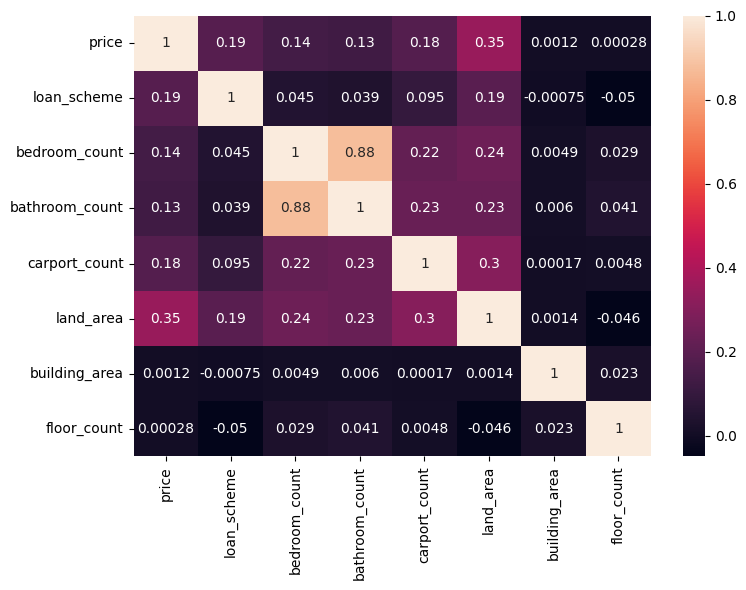

In [327]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(numeric_only=True),annot=True)
plt.tight_layout()
plt.show()

Correlation between price and land area is considered logical, since the causality is the more land someone owns the higher the price the owner pays. However we notice how there seems to be a lot of outliers based on highly expensive houses and land area above 3000 square meters.

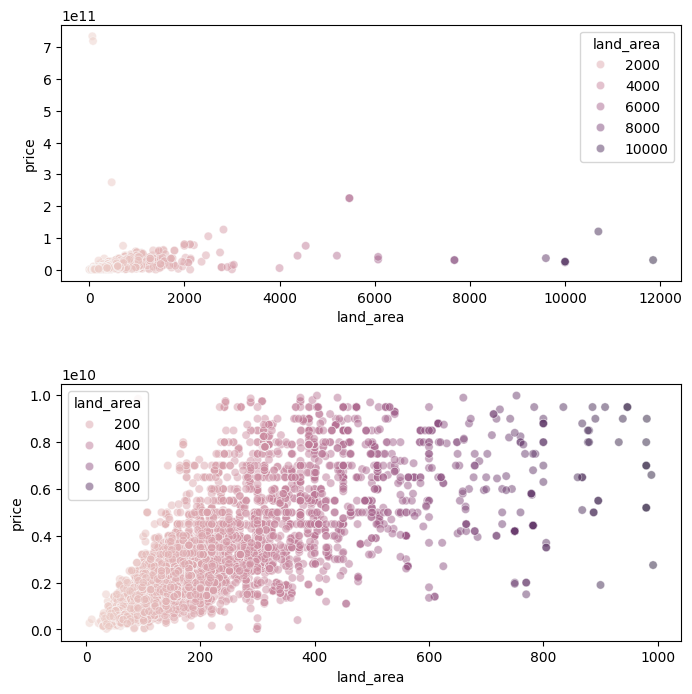

In [328]:
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(2, 1, 1)
sns.scatterplot(data=df, x='land_area', y='price',
                hue='land_area', alpha=0.5, ax=ax)
ax = fig.add_subplot(2, 1, 2)
sns.scatterplot(data=df.query('`price` < 1e10 & `land_area`< 1000'),
                x='land_area', y='price', hue='land_area', alpha=0.5, ax=ax)
plt.show()

Now since we want to know how districts affect prices, it will be best to see the features in a map. This method requires .json files that has coordinates for geopandas to plot, there are a lot of open source dataset on internet, the one I am using is from this [github link](https://github.com/tryfatur/geojson-bandung). Thank you tryfatur for the contribution!

In [329]:
# For Mapping purposes

# Read geopandas data that contains districts in Bandung
districts = gpd.read_file("kecamatan.json")

# Match district names formatting (case sensitive!)
districts = districts.replace('Buahbatu','Buah Batu')
districts = districts.replace('Sumur Bandung','Sumurbandung')
districts = districts.replace('Gedebage','Gede Bage')

First create the general function for map plot, later state the aggregate function to see features involved

In [330]:
def plot_district_heatmap(districts, agg_price,
                          column=None, title='Aggregate Price Heatmap',
                          cmap_name='RdBu',ax=None,annot=True):
    """
    Function to visualize geospatial data with heatmap overlay and annotations.

    Parameters:
    - districts: GeoDataFrame containing district geometries.
    - agg_price: GeoDataFrame with aggregate price data, including 'geometry' and the column to be plotted.
    - column: The column used to create the heatmap (default is 'price').
    - title: Title of the plot.
    - cmap_name: Name of the colormap to be used for the heatmap (default is 'RdBu').
    """
    # Define the colormap and normalization based on the data column
    cmap = plt.get_cmap(cmap_name)
    norm = plt.Normalize(vmin=agg_price[column].min(),
                         vmax=agg_price[column].max())

    # Function to calculate luminance (brightness) for better readability
    def get_text_color(rgb_color):
        r, g, b = rgb_color[:3]
        luminance = 0.299*r + 0.587*g + 0.114*b
        return 'black' if luminance > 0.3 else 'white'

    # Visualize basic geospatial data with heatmap overlay
    if ax is None:
      fig, ax = plt.subplots(figsize=(12, 8))

    # Add the title to the plot
    ax.set_title(title)

    # Plot the boundaries of the districts
    districts.boundary.plot(ax=ax, linewidth=0.1)

    # Create a heatmap using the specified column
    agg_price.plot(column=column, cmap=cmap_name, ax=ax, legend=True,
                   missing_kwds={"color": "lightgrey", "edgecolor": "red",
                                 "hatch": "///", "label": "Missing values"})

    # Remove all spines
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Remove x and y ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # Add annotations to each district based on its centroid
    if annot is True:
      for idx, row in agg_price.iterrows():
          centroid = row['geometry'].centroid
          norm_value = norm(row[column])
          rgb_color = cmap(norm_value)
          text_color = get_text_color(rgb_color)

          # Annotate with district name or value
          ax.annotate(text=row['nama_kecamatan'],
                      xy=(centroid.x, centroid.y),
                      horizontalalignment='center', fontsize=8,
                      color=text_color)

    if ax is None:
      plt.show()

The average prices object and plotting are provided below. We can see that the blue-colored districts have higher average prices than other districts. These districts are typically where the upper class resides, entertainment and tourism thrive, and old colonial houses or buildings still remain. It makes sense that these areas have the highest average house prices, regardless of the price distribution within each district.

Areas such as Sukasari, Cidadap, and Sukajadi are also favored by most wealthy people in Bandung. These districts are immune to flooding due to their higher altitude compared to other districts and are strategically located near malls and offices in Bandung. They are also the closest to Toll Road gate entrances.

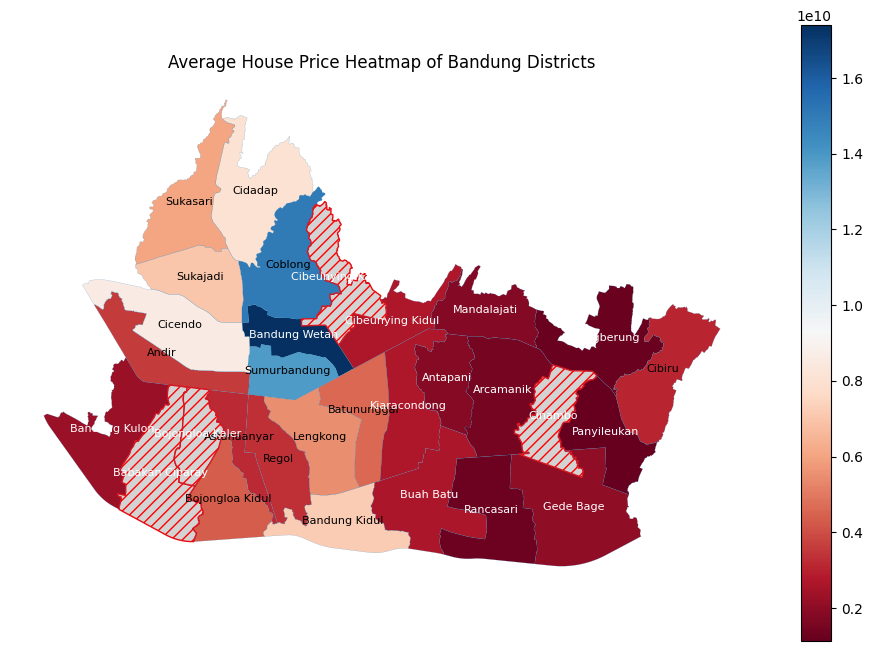

In [331]:
avg_price = df.groupby('nama_kecamatan')['price'].mean()
avg_price = districts.join(avg_price, on="nama_kecamatan")

plot_district_heatmap(districts, avg_price,
                      column='price',
                      title='Average House Price Heatmap of Bandung Districts')

Now see how many houses are listed based on their districts based on the sample we have. Based on the website that was scrapped, most listings are houses from Bojongloa Kidul and district with the least house listings is Cibeunying Kidul. This is hard to interpret because there are a lot of other ways to sell house and web listing is not the only method. However, this shows how easy to find features using the map plot function.

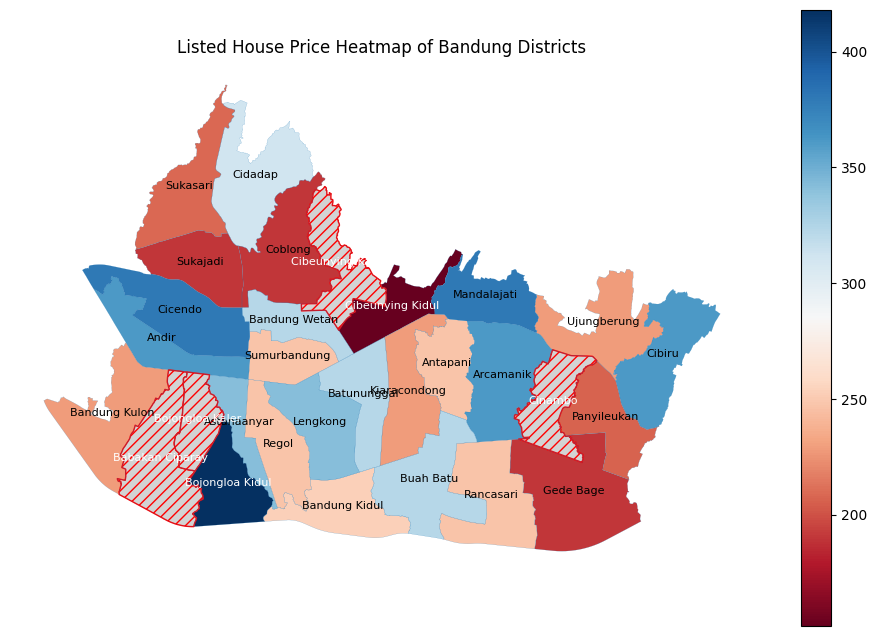

In [332]:
count_price = df.groupby('nama_kecamatan')['price'].count()
count_price = districts.join(count_price, on="nama_kecamatan")

plot_district_heatmap(districts, count_price,
                      column='price',
                      title='Listed House Price Heatmap of Bandung Districts')

Here's further evidence of how useful the aggregate map plot function is. Let's say we want to know the variance based on districts. We can easily apply the same aggregation by variance and observe the spread between house prices in our scraped dataset.

Based on our current dataset, we can see that most districts have a similar price spread, except for Bandung Kidul and Cibiru, which show a more significant spread compared to other districts.

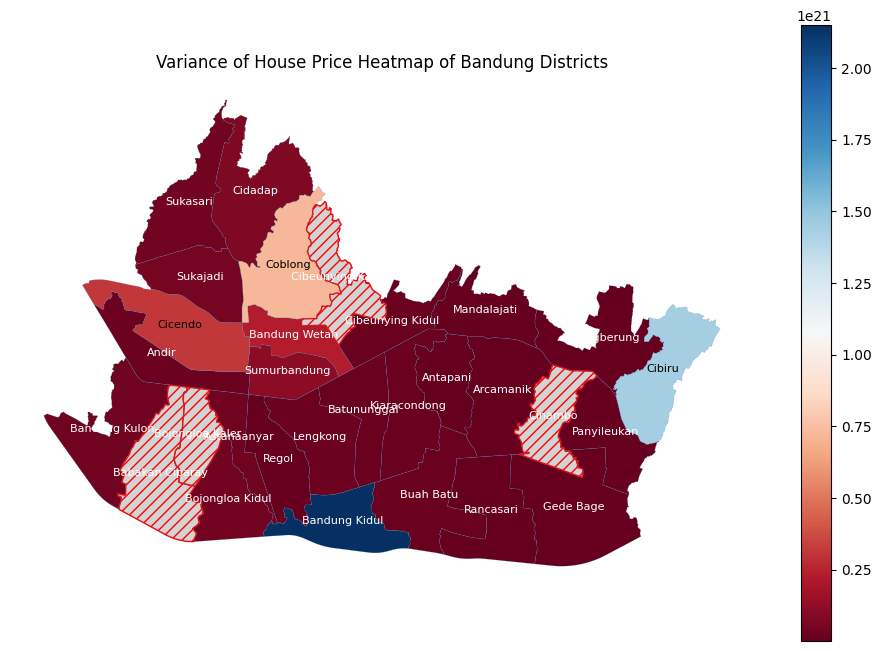

In [333]:
var_price = df.groupby('nama_kecamatan')['price'].var()
var_price = districts.join(var_price, on="nama_kecamatan")

plot_district_heatmap(districts, var_price,
                      column='price',
                      title='Variance of House Price Heatmap of Bandung Districts')

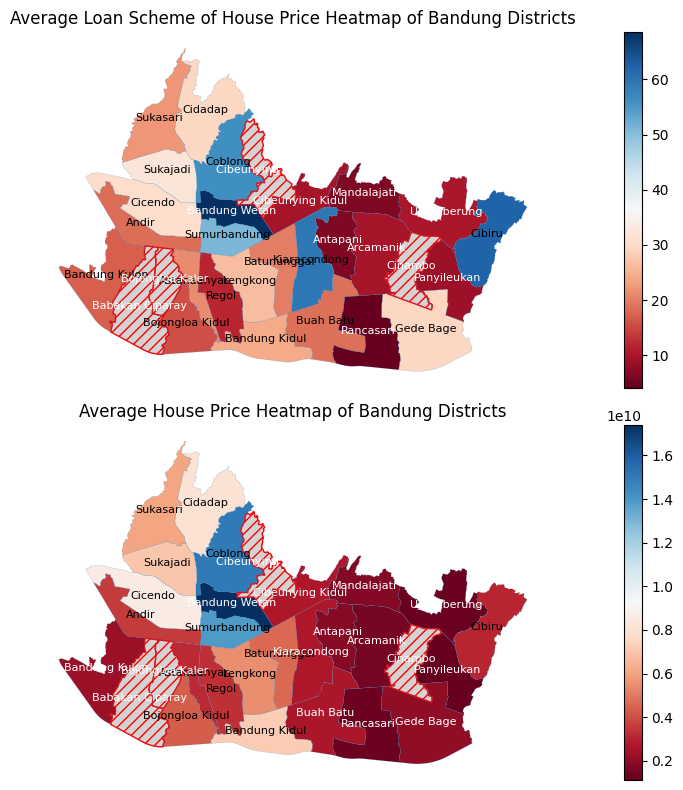

In [334]:
avgloan_price = df.groupby('nama_kecamatan')['loan_scheme'].mean()
avgloan_price = districts.join(avgloan_price, on="nama_kecamatan")

# For easier comparison, we can create subplots and assign the axis
fig, axs = plt.subplots(2, 1, figsize=(15, 8))

# First plot: Average Loan Scheme
plot_district_heatmap(districts, avgloan_price,
                      column='loan_scheme',
                      title='Average Loan Scheme of House Price Heatmap of Bandung Districts',
                      ax=axs[0])

# Second plot: Average House Price
plot_district_heatmap(districts, avg_price,
                      column='price',
                      title='Average House Price Heatmap of Bandung Districts',
                      ax=axs[1])


plt.tight_layout()
plt.show()

Notice that we do not have data for certain districts:

*   cinambo
*   cibeunying kaler
*   babakan ciparay
*   bojongloa kaler

to solve this issue, I use the same method on web scrapping used on dataset from Kaggle.com

In [335]:
# Chrome web scrapping extension was not able to scroll through pages, resulting multiple csv files

cinambo1 = pd.read_csv('cinambo.csv',header=None)
cinambo2 = pd.read_csv('cinambo1.csv',header=None)
cinambo3 = pd.read_csv('cinambo2.csv',header=None)

# Manually cleaning each csv due to possibility of different scrapped informations

# Adding columns for concating purposes
cinambo1 = cinambo1.drop(0).drop(6,axis=1)
cinambo1.columns = ['type', 'price', 'loan_scheme', 'bedroom_count', 'bathroom_count',
 'land_area', 'building_area', 'house_name']

cinambo2 = cinambo2.drop(0)
cinambo2.columns = ['type', 'price', 'loan_scheme', 'bedroom_count', 'bathroom_count',
 'land_area', 'building_area', 'house_name']

cinambo3 = cinambo3.drop(0)
cinambo3.columns = ['type', 'price', 'loan_scheme', 'bedroom_count', 'bathroom_count',
 'land_area', 'building_area', 'house_name']

cinambo = pd.concat([cinambo1,cinambo2,cinambo3])
cinambo['location'] = 'Cinambo, Bandung'

# Filter non-houses
cinambo = cinambo[cinambo['type'] == 'Rumah']

cinambo.head(3)

type           price                  loan_scheme bedroom_count  \
1  Rumah  Rp 1,15 Miliar  Cicilan: 4 Jutaan per bulan             3   
2  Rumah  Rp 1,17 Miliar  Cicilan: 4 Jutaan per bulan             2   
3  Rumah     Rp 730 Juta  Cicilan: 2 Jutaan per bulan             2   

  bathroom_count land_area building_area  \
1              2    100 m²        180 m²   
2              1     80 m²         54 m²   
3              1     74 m²         43 m²   

                                          house_name          location  
1  Rumah 2 Lantai Cinambo Indah dekat Mizan Soeka...  Cinambo, Bandung  
2  Rumah Baru Cinambo Dekat Kampus Uin Bandung 1 ...  Cinambo, Bandung  
3  Luas Tanah 74m Luas Bangunan 43m Lebar Muka 6m...  Cinambo, Bandung

Concat to original dataframe (object_name: df)

**BE CAREFUL TO NOT OVERWRITE CLEAN DATA**

In [336]:
# Clean Cinambo only
cinambo = clean_data(cinambo) # Careful it returns the dataframe

cinambo['price'] = cinambo['price'].apply(clean_price)

get_lantai(cinambo,'house_name')

<ipython-input-320-fc6591835efb>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['loan_scheme'] = df['loan_scheme'].apply(lambda x: float(x.split(' ')[1]))
<ipython-input-320-fc6591835efb>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['nama_kecamatan'] = df['location'].apply(lambda x: x.split(',')[0])


type         price  loan_scheme bedroom_count bathroom_count  land_area  \
1   Rumah  1.150000e+09          4.0             3              2        100   
2   Rumah  1.170000e+09          4.0             2              1         80   
3   Rumah  7.300000e+08          2.0             2              1         74   
4   Rumah  9.000000e+08          3.0             2              1         81   
6   Rumah  1.200000e+09          4.0             2              1         81   
7   Rumah  1.900000e+09          7.0             3              2         81   
8   Rumah  7.600000e+08          2.0             2              1         72   
9   Rumah  8.100000e+08          3.0             2              1         74   
10  Rumah  7.500000e+08          2.0             3              2        100   
11  Rumah  1.600000e+09          6.0             3              2        153   
12  Rumah  1.000000e+09          3.0             3              2        125   
14  Rumah  1.370000e+09          5.0             3              2        102   
15  Rumah  1.100000e+09          4.0             4              2        128   
16  Rumah  1.300000e+09          4.0             4              2         98   
19  Rumah  4.810000e+08          1.0             2              1        119   
20  Rumah  1.500000e+09          5.0             3              2        108   
1   Rumah  1.000000e+09          3.0             2              1         53   
2   Rumah  1.450000e+09          5.0             4              3        120   
3   Rumah  7.500000e+08          2.0             3              1        100   
4   Rumah  8.000000e+08          3.0             3              1        100   
5   Rumah  8.250000e+08          3.0             2              1         96   
6   Rumah  9.000000e+08          3.0             3              2        150   
7   Rumah  1.000000e+09          3.0             3              2        100   
8   Rumah  8.950000e+08          3.0             2              1        136   
9   Rumah  1.550000e+09          5.0             4              3        180   
10  Rumah  1.550000e+09          5.0             4              3        180   
11  Rumah  1.250000e+09          4.0             2              2        110   
12  Rumah  7.850000e+08          3.0             2              1         75   
13  Rumah  9.260000e+08          3.0             2              1         81   
14  Rumah  9.700000e+08          3.0             2              2        123   
15  Rumah  7.700000e+08          2.0             2              1         72   
16  Rumah  7.500000e+08          2.0             3              1        100   
18  Rumah  1.970000e+09          7.0             2              2        339   
19  Rumah  1.500000e+09          5.0             5              4        126   
20  Rumah  9.000000e+08          3.0             2              1        136   
1   Rumah  1.870000e+09          7.0             3              2         81   
3   Rumah  1.950000e+09          7.0             6              4        145   
5   Rumah  8.350000e+08          3.0             2              1         74   
6   Rumah  6.000000e+08          2.0             2              1         65   
7   Rumah  9.260000e+08          3.0             2              1         81   
8   Rumah  9.250000e+08          3.0             2              1         81   
9   Rumah  9.250000e+08          3.0             2              1         81   
10  Rumah  1.100000e+09          4.0             4              2        128   
11  Rumah  1.300000e+09          4.0             3              2         96   
15  Rumah  1.100000e+09          4.0             3              1        122   
16  Rumah  6.750000e+08          2.0             2              1         72   
17  Rumah  4.810000e+08          1.0             2              1        119   
20  Rumah  8.900000e+08          3.0             2              1        126   

    building_area                                         house_name  \
1           

In [337]:
# Concat new dataframe containing dataframe from csv

df = pd.concat([df,cinambo])
df = df.reset_index(drop=True)

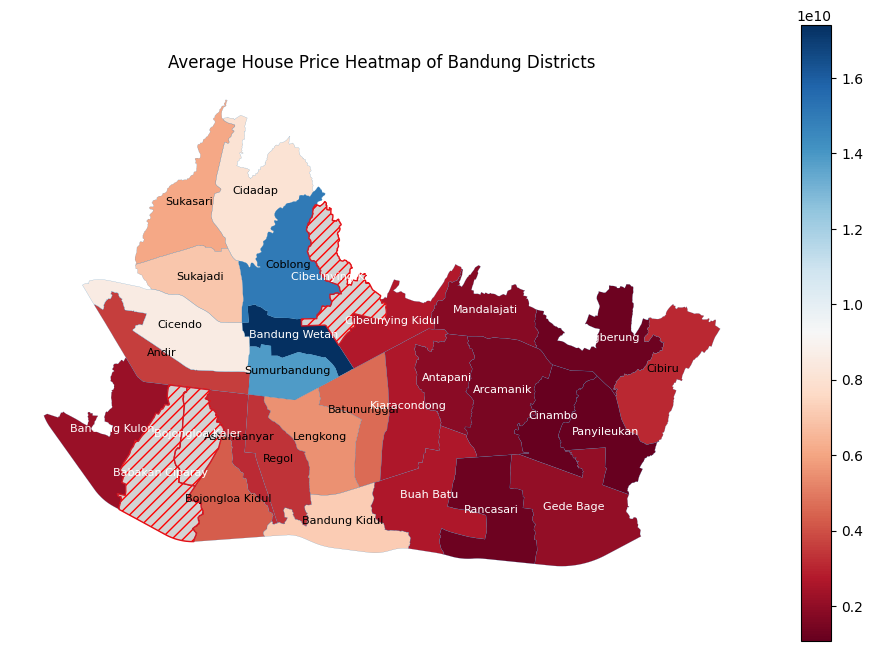

In [338]:
# Now let's check how is our average prices

avg_price = df.groupby('nama_kecamatan')['price'].mean()
avg_price = districts.join(avg_price, on="nama_kecamatan")

plot_district_heatmap(districts, avg_price,
                      column='price',
                      title='Average House Price Heatmap of Bandung Districts')

It was all the available data I could scrape for Cinambo district. Surprisingly, there are no more house nor property on sale on the other districts I could find online.

List of districts with no property on sale:

*   cibeunying kaler
*   babakan ciparay
*   bojongloa kaler

We have to just list these districts for unavailability.

We notice some irregular outliers, let's find out hidden features in house_name for properties that would not be considered as house (example: villa, gudang, etc.)

In [339]:
df_villa = df[df['house_name'].str.lower().str.contains('villa')]
df_villa.describe().T

count          mean           std          min          25%  \
price           61.0  6.064115e+09  8.442765e+09  273000000.0  680000000.0   
loan_scheme     61.0  2.206557e+01  3.128091e+01          1.0          2.0   
carport_count   59.0  2.610169e+00  3.671967e+00          0.0          0.5   
land_area       61.0  1.329574e+03  2.594830e+03         60.0        119.0   
building_area   61.0  2.943279e+02  3.110682e+02         36.0         75.0   
floor_count     61.0  1.114754e+00  3.213700e-01          1.0          1.0   

                        50%           75%           max  
price          2.500000e+09  7.500000e+09  3.200000e+10  
loan_scheme    9.000000e+00  2.700000e+01  1.180000e+02  
carport_count  1.000000e+00  3.000000e+00  1.500000e+01  
land_area      3.280000e+02  1.000000e+03  1.185000e+04  
building_area  2.000000e+02  4.000000e+02  1.700000e+03  
floor_count    1.000000e+00  1.000000e+00  2.000000e+00

In [340]:
df.describe().T

count          mean           std         min           25%  \
price          7659.0  4.956890e+09  1.471760e+10  12000000.0  1.115000e+09   
loan_scheme    7659.0  2.517561e+01  8.073153e+01         1.0  4.000000e+00   
carport_count  7611.0  1.374721e+00  1.927984e+00         0.0  0.000000e+00   
land_area      7657.0  2.735151e+02  4.393793e+02         6.0  1.020000e+02   
building_area  7658.0  6.391072e+02  3.434857e+04         1.0  1.000000e+02   
floor_count    7659.0  1.172412e+00  4.262049e-01         1.0  1.000000e+00   

                        50%           75%           max  
price          2.250000e+09  4.700000e+09  7.350000e+11  
loan_scheme    8.000000e+00  1.800000e+01  9.850000e+02  
carport_count  1.000000e+00  2.000000e+00  4.000000e+01  
land_area      1.640000e+02  3.120000e+02  1.185000e+04  
building_area  1.800000e+02  3.000000e+02  3.006000e+06  
floor_count    1.000000e+00  1.000000e+00  4.000000e+00

Notice how the data with the word 'villa' in house_name deviates overall dataset? Considering it is only 61 rows, I think it is better to remove these non-house listings since they are not actual house. Houses are more versatile in terms of location (non-exclusive), spanning urban, suburban, and rural settings (non-niche).

In [341]:
df = df[~df['house_name'].str.lower().str.contains('villa')]
df[df['house_name'].str.lower().str.contains('villa')] # Check new df

Empty DataFrame
Columns: [type, status, price, loan_scheme, house_name, bedroom_count, bathroom_count, carport_count, land_area, building_area, nama_kecamatan, floor_count]
Index: []

Now let's do the same thing on the keyword 'gudang'

In [342]:
df_gudang = df[df['house_name'].str.lower().str.contains('gudang')]
df_gudang.describe().T

count          mean           std           min           25%  \
price           27.0  1.030741e+10  9.153170e+09  1.350000e+09  3.900000e+09   
loan_scheme     27.0  3.788889e+01  3.400490e+01  5.000000e+00  1.400000e+01   
carport_count   27.0  4.000000e+00  8.086075e+00  0.000000e+00  0.000000e+00   
land_area       27.0  7.413333e+02  6.431776e+02  1.800000e+02  2.745000e+02   
building_area   27.0  5.872593e+02  3.539251e+02  1.500000e+02  3.625000e+02   
floor_count     27.0  1.148148e+00  3.620140e-01  1.000000e+00  1.000000e+00   

                        50%           75%           max  
price          7.000000e+09  1.375000e+10  3.500000e+10  
loan_scheme    2.600000e+01  5.100000e+01  1.300000e+02  
carport_count  1.000000e+00  2.500000e+00  3.000000e+01  
land_area      5.100000e+02  7.225000e+02  2.131000e+03  
building_area  4.500000e+02  8.625000e+02  1.600000e+03  
floor_count    1.000000e+00  1.000000e+00  2.000000e+00

In [343]:
df = df[~df['house_name'].str.lower().str.contains('gudang')]
df[df['house_name'].str.lower().str.contains('gudang')] # Check new df

Empty DataFrame
Columns: [type, status, price, loan_scheme, house_name, bedroom_count, bathroom_count, carport_count, land_area, building_area, nama_kecamatan, floor_count]
Index: []

For better land and building area threshold, data from [arcgis.com suggest that average household size in Indonesia by 2022 is 3.8](https://www.arcgis.com/home/item.html?id=7d1b66f2aa374167a337c6b0e386fc80#:~:text=Nationally%2C%20the%20average%20household%20size,household%20size%20(people%20per%20household)) and regulation regarding minimum land and building size by PUPR minister is stated below.

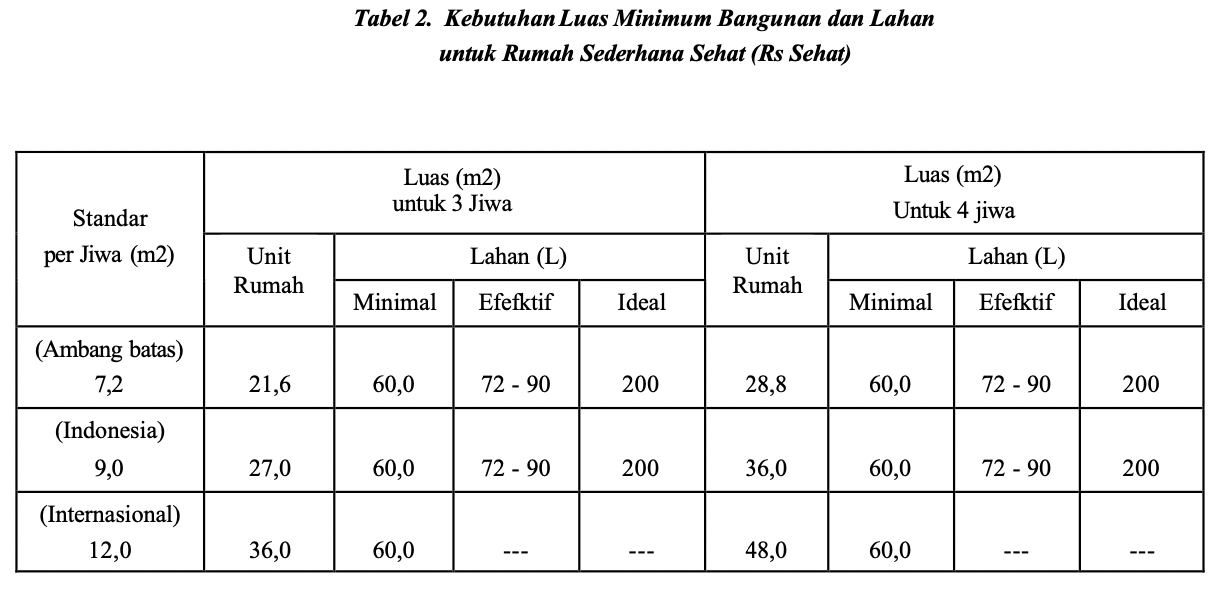

Rounding up household size to 4, we can set a threshold for houses we should be dealing legally based on the current regulation. Since we only have 0.2% ineligible houses, it won't impact the data that much to remove these houses. We also provide a stricter dataset by following eligibility guidelines.

In [344]:
df_eligible = df.query('`land_area` >= 60 & `building_area` >= 28.8')
df_ineligible = df.query('`land_area` < 60 & `building_area` < 28.8')

print(f'Ineligible House Listing {round(len(df_ineligible)/len(df_eligible)*100,3)}%')

Ineligible House Listing 0.205%


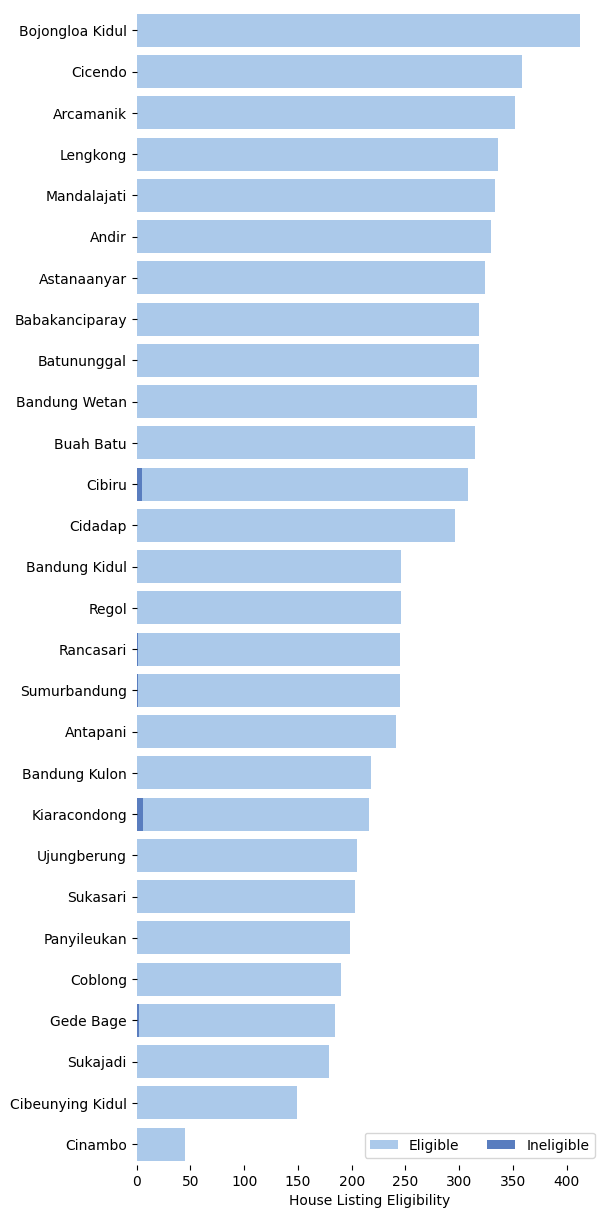

In [345]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="land_area", y="nama_kecamatan",
            data=df_eligible.groupby('nama_kecamatan')[['land_area', 'building_area']].count().sort_values(['land_area'],ascending=False),
            label="Eligible", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="land_area", y="nama_kecamatan",
            data=df_ineligible.groupby('nama_kecamatan')[['land_area', 'building_area']].count().sort_values(['land_area'],ascending=False),
            label="Ineligible", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="", xlabel="House Listing Eligibility")
sns.despine(left=True, bottom=True)

Ineligible house listings are under 3%, even after it is grouped by districts the ineligible listings are still small to each districts. These data can be considered as outliers, thus can be removed.

In [346]:
df = df_eligible
df.head()

type   status         price  loan_scheme  \
0  Rumah  Premier  2.100000e+09          7.0   
1  Rumah      NaN  4.100000e+09         15.0   
2  Rumah      NaN  3.300000e+09         12.0   
4  Rumah      NaN  1.300000e+09          4.0   
5  Rumah      NaN  3.600000e+09         13.0   

                                          house_name bedroom_count  \
0  Rumah 2 Lantai Bagus Sertifikat Hak Milik di M...             3   
1                    Rumah Cantik @ Andir (Sudirman)             3   
2  Jual Cepat Rumah di Maleber Rajawali Bisa Untu...             5   
4  Jual Rumah Murah Bisa Dijadikan Kos”an Di Jala...            11   
5  Rumah 2,5 Lantai Strategis SHM di Komplek Kert...             5   

  bathroom_count  carport_count  land_area  building_area nama_kecamatan  \
0              2            2.0      137.0          170.0          Andir   
1              2            3.0      202.0          300.0          Andir   
2              2            1.0      350.0          258.0          Andir   
4              3            0.0      176.0          176.0          Andir   
5              3            1.0      184.0          234.0          Andir   

   floor_count  
0          2.0  
1          1.0  
2          1.0  
4          1.0  
5          2.5

We want to see how the histogram plot on our data. As expected from our previous overview, there must be a huge outlier since the house prices are mostly under IDR 10 Million.

<Axes: xlabel='price', ylabel='Count'>

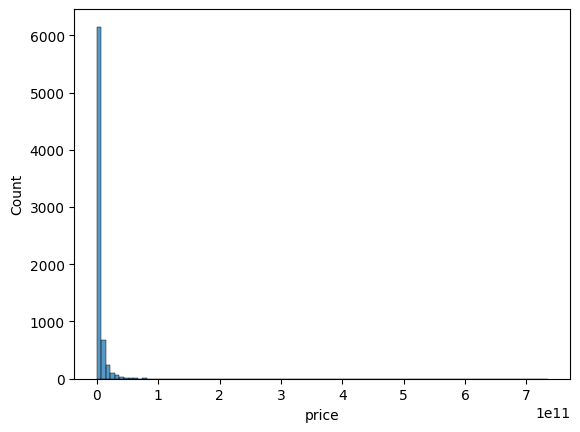

In [347]:
sns.histplot(data=df,x='price',bins=100)

In [348]:
# Let's check based on the percentage

above_50M = df.query('`price`>5e11')
above_10M = df.query('`price`>1e10')
below_10M = df.query('`price`<=1e10')

print(f'Houses Above 10 Billion IDR {round(len(above_10M)/len(below_10M)*100,3)}%')
print(f'Houses Above 50 Billion IDR {round(len(above_50M)/len(below_10M)*100,3)}%')

Houses Above 10 Billion IDR 11.268%
Houses Above 50 Billion IDR 0.03%


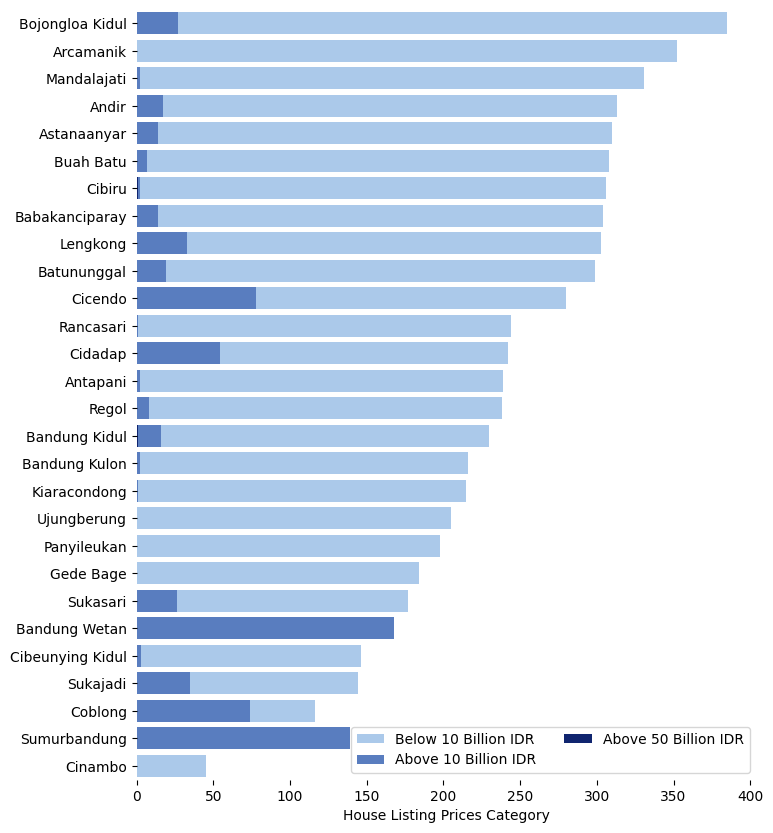

In [349]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(8, 10))

# Bigger Barplot Here
sns.set_color_codes("pastel")
sns.barplot(x="price", y="nama_kecamatan",
            data=below_10M.groupby('nama_kecamatan')['price'].count().sort_values(ascending=False).reset_index(),
            label="Below 10 Billion IDR", color="b")

# Smaller Barplot here
sns.set_color_codes("muted")
sns.barplot(x="price", y="nama_kecamatan",
            data=above_10M.groupby('nama_kecamatan')['price'].count().sort_values(ascending=False).reset_index(),
            label="Above 10 Billion IDR", color="b")

# Smaller Barplot here
sns.set_color_codes("dark")
sns.barplot(x="price", y="nama_kecamatan",
            data=above_50M.groupby('nama_kecamatan')['price'].count().sort_values(ascending=False).reset_index(),
            label="Above 50 Billion IDR", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="", xlabel="House Listing Prices Category")
sns.despine(left=True, bottom=True)

Bandung Wetan and Sumurbandung District have the highest prices in Bandung. This is considered normal because both districts are the core of Bandung, thus we have to keep these house listings for prediction

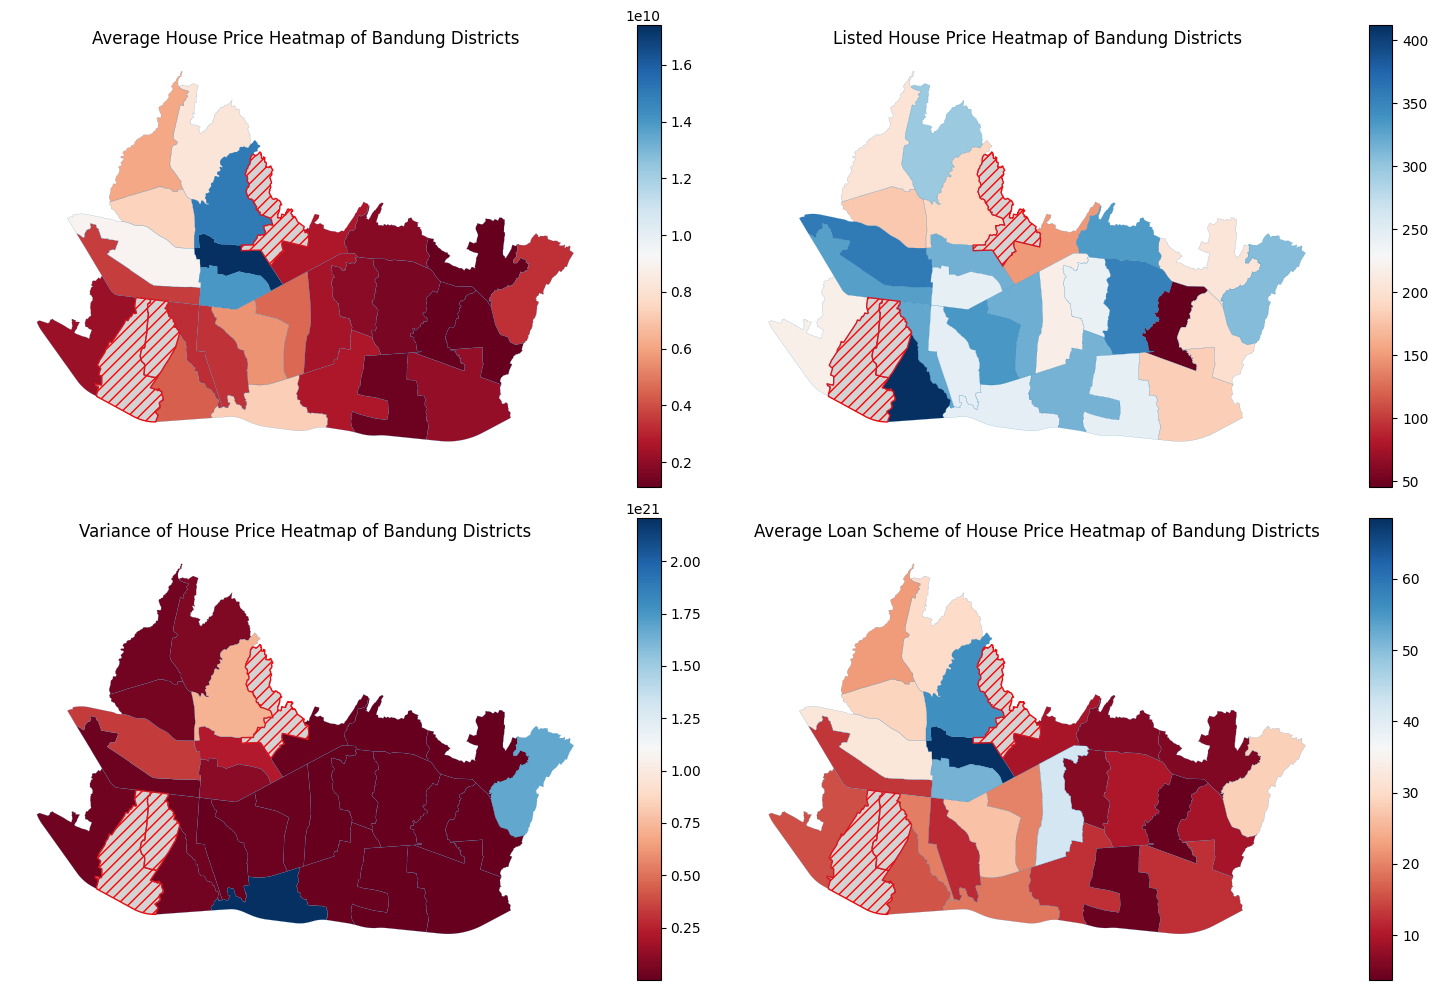

In [350]:
# Now let's check how is our previous aggregated data by district
annot = False

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

avg_price = df.groupby('nama_kecamatan')['price'].mean()
avg_price = districts.join(avg_price, on="nama_kecamatan")

plot_district_heatmap(districts, avg_price,
                      column='price',
                      annot=annot,
                      title='Average House Price Heatmap of Bandung Districts',
                      ax=axs[0,0])

count_price = df.groupby('nama_kecamatan')['price'].count()
count_price = districts.join(count_price, on="nama_kecamatan")

plot_district_heatmap(districts, count_price,
                      column='price',
                      annot=annot,
                      title='Listed House Price Heatmap of Bandung Districts',
                      ax=axs[0,1])

var_price = df.groupby('nama_kecamatan')['price'].var()
var_price = districts.join(var_price, on="nama_kecamatan")

plot_district_heatmap(districts, var_price,
                      column='price',
                      annot=annot,
                      title='Variance of House Price Heatmap of Bandung Districts',
                      ax=axs[1,0])

avgloan_price = df.groupby('nama_kecamatan')['loan_scheme'].mean()
avgloan_price = districts.join(avgloan_price, on="nama_kecamatan")

plot_district_heatmap(districts, avgloan_price,
                      column='loan_scheme',
                      annot=annot,
                      title='Average Loan Scheme of House Price Heatmap of Bandung Districts',
                      ax=axs[1,1])

plt.tight_layout()
plt.show()

Let's see other features outside districts. Houses in crowded area tend to have smaller land area and more likely to be a storey house. let's see the distribution correlation between land area and price, differentiated by other feature

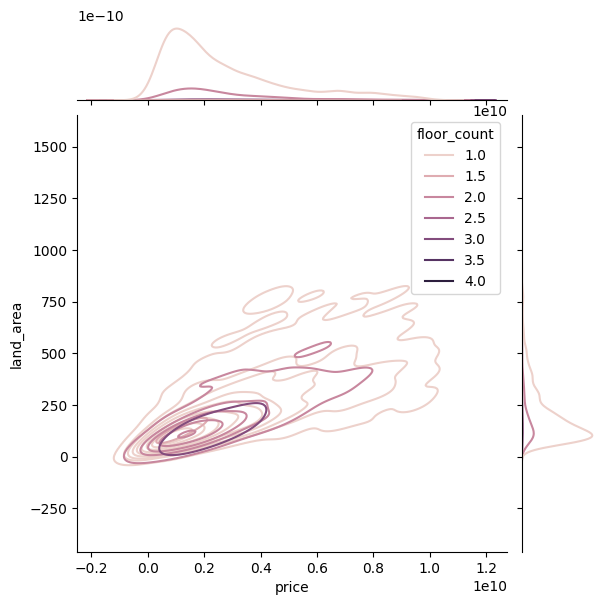

In [351]:
# Floor count
data = df.query('`price` < 1e10 & `land_area`< 1000')
sns.jointplot(x=data['price'], y=data['land_area'],
              kind='kde', hue=data['floor_count'])
plt.show()

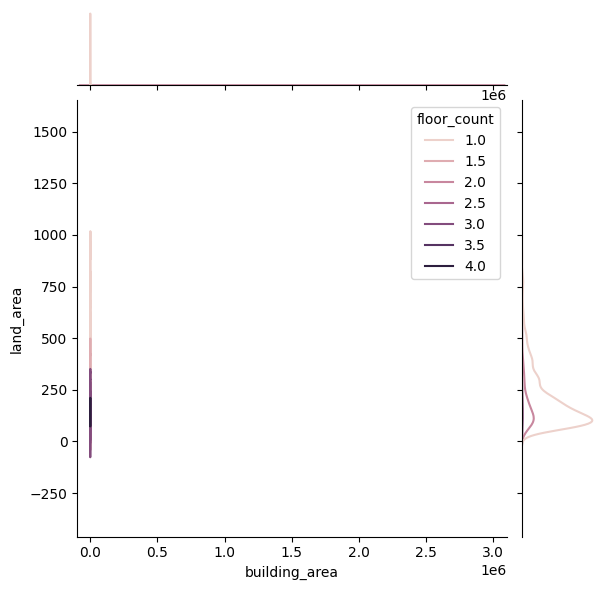

In [352]:
# loan scheme
data = df.query('`price` < 1e10 & `land_area`< 1000')
sns.jointplot(x=data['building_area'], y=data['land_area'],
              kind='kde', hue=data['floor_count'])
plt.show()

We notice how a simple plot can detect outliers. Now, let's see if these outliers are caused by erroneous data that needs to be removed. Building area is typically measured by the number of floors a building has. It's common for a building area in Bandung to be slightly larger than the land area due to features like rooftop canopies, and the house may also be reported to have only one floor. This creates some flexibility for houses listed with incorrect or unregistered floor counts, giving us a rule of thumb for sorting houses that satisfy the equation:

building_area = land_area * (floor_count + 1.1)

In [353]:
df[df['building_area'] > df['land_area']*(df['floor_count']+1.1)]

type status         price  loan_scheme  \
371   Rumah    NaN  8.650000e+08          3.0   
399   Rumah    NaN  1.900000e+09          7.0   
401   Rumah    NaN  1.900000e+09          7.0   
402   Rumah    NaN  1.900000e+09          7.0   
408   Rumah    NaN  9.400000e+09         34.0   
...     ...    ...           ...          ...   
7480  Rumah    NaN  1.700000e+09          6.0   
7583  Rumah    NaN  2.000000e+09          7.0   
7586  Rumah    NaN  1.700000e+09          6.0   
7599  Rumah    NaN  1.700000e+09          6.0   
7602  Rumah    NaN  4.000000e+09         14.0   

                                             house_name bedroom_count  \
371   Rumah Tengah Kota Astana anyar Dijual Cepat Murah             3   
399   Rumah Siap Huni di Pusat Kota di Astana Anyar,...             5   
401   Murah !! Rumah pusat kota siap huni di Astanaa...             5   
402       Rumah Dijual Modern Siap Huni di Astana Anyar             5   
408   Hotel Cantik Mewah Terawat Strategis Di Mohamm...            38   
...                                                 ...           ...   
7480                            Rumah  Komplek Pasadena             3   
7583  Dijual Rumah Tinggal Artistik Siap Huni di Pas...             3   
7586    Rumah Full Furnished Siap Huni Pasadena Bandung             4   
7599    Rumah Full Furnished Siap Huni Pasadena Bandung             4   
7602   RUMAH NYAMAN SIAP HUNI DI SAYAP SUDIRMAN BANDUNG             4   

     bathroom_count  carport_count  land_area  building_area  nama_kecamatan  \
371               2            0.0       65.0          225.0     Astanaanyar   
399               3            2.0      106.0          240.0     Astanaanyar   
401               3            2.0      106.0          240.0     Astanaanyar   
402               3            0.0      106.0          240.0     Astanaanyar   
408              38            0.0      724.0         1777.0     Astanaanyar   
...             ...            ...        ...            ...             ...   
7480              3            0.0      100.0          218.0  Babakanciparay   
7583              2            1.0      100.0          218.0  Babakanciparay   
7586              2            0.0      113.0          250.0  Babakanciparay   
7599              2            0.0      113.0          250.0  Babakanciparay   
7602              4            0.0      170.0          400.0  Babakanciparay   

      floor_count  
371           1.0  
399           1.0  
401           1.0  
402           1.0  
408           1.0  
...           ...  
7480          1.0  
7583          1.0  
7586          1.0  
7599          1.0  
7602          1.0  

[164 rows x 12 columns]

So we have 164 house listings that are more likely contain false data or ineligible listings. Since we are unable to decide the actual casuality of this illogical building area-floor count correlation and the amount are relatively small, it's best to remove these data.

In [354]:
df = df[df['building_area'] <= df['land_area']*(df['floor_count']+1.1)]
df.describe().T

count          mean           std         min           25%  \
price          7163.0  5.059811e+09  1.512712e+10  12000000.0  1.200000e+09   
loan_scheme    7163.0  2.187575e+01  6.429502e+01         1.0  4.000000e+00   
carport_count  7118.0  1.367097e+00  1.741063e+00         0.0  0.000000e+00   
land_area      7163.0  2.718089e+02  3.683444e+02        60.0  1.050000e+02   
building_area  7163.0  2.428790e+02  2.304614e+02        30.0  1.020000e+02   
floor_count    7163.0  1.176393e+00  4.301013e-01         1.0  1.000000e+00   

                        50%           75%           max  
price          2.300000e+09  4.800000e+09  7.350000e+11  
loan_scheme    8.000000e+00  1.800000e+01  9.850000e+02  
carport_count  1.000000e+00  2.000000e+00  3.000000e+01  
land_area      1.710000e+02  3.190000e+02  1.070000e+04  
building_area  1.800000e+02  3.000000e+02  6.000000e+03  
floor_count    1.000000e+00  1.000000e+00  4.000000e+00

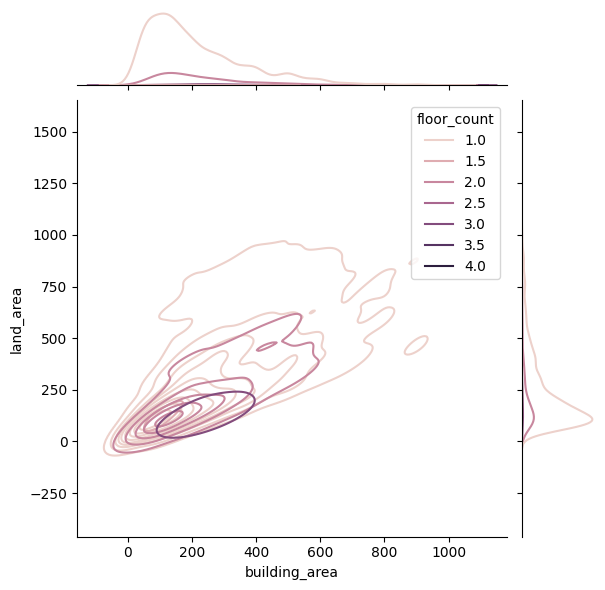

In [355]:
data = df.query('`building_area` < 1000 & `land_area`< 1000')
sns.jointplot(x=data['building_area'], y=data['land_area'],
              kind='kde', hue=data['floor_count'])
plt.show()

House prices can fluctuate according to sellers and buyers based on speculations and macroeconomic condition. House prices are also not limited to it's history, hidden features like luxuries, furnitures, pools etc. However, it is best to work based on reasonable existing features like what we have on scrapped data. Now that we have building_area that are smaller than land_area, carport_count & floow_count that was scrapped from house_name, we have more confidence on trying to predict the population data with our sample data using various models that will be tested.

In [356]:
df.describe().T

count          mean           std         min           25%  \
price          7163.0  5.059811e+09  1.512712e+10  12000000.0  1.200000e+09   
loan_scheme    7163.0  2.187575e+01  6.429502e+01         1.0  4.000000e+00   
carport_count  7118.0  1.367097e+00  1.741063e+00         0.0  0.000000e+00   
land_area      7163.0  2.718089e+02  3.683444e+02        60.0  1.050000e+02   
building_area  7163.0  2.428790e+02  2.304614e+02        30.0  1.020000e+02   
floor_count    7163.0  1.176393e+00  4.301013e-01         1.0  1.000000e+00   

                        50%           75%           max  
price          2.300000e+09  4.800000e+09  7.350000e+11  
loan_scheme    8.000000e+00  1.800000e+01  9.850000e+02  
carport_count  1.000000e+00  2.000000e+00  3.000000e+01  
land_area      1.710000e+02  3.190000e+02  1.070000e+04  
building_area  1.800000e+02  3.000000e+02  6.000000e+03  
floor_count    1.000000e+00  1.000000e+00  4.000000e+00

In [357]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7163 entries, 0 to 7658
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   type            7163 non-null   object 
 1   status          141 non-null    object 
 2   price           7163 non-null   float64
 3   loan_scheme     7163 non-null   float64
 4   house_name      7163 non-null   object 
 5   bedroom_count   7163 non-null   object 
 6   bathroom_count  7163 non-null   object 
 7   carport_count   7118 non-null   float64
 8   land_area       7163 non-null   float64
 9   building_area   7163 non-null   float64
 10  nama_kecamatan  7163 non-null   object 
 11  floor_count     7163 non-null   float64
dtypes: float64(6), object(6)
memory usage: 727.5+ KB


there are still some null data,

* status
* carport_count
* land_area
* building_area

let's see if they can be dropped

In [358]:
df.describe().T

count          mean           std         min           25%  \
price          7163.0  5.059811e+09  1.512712e+10  12000000.0  1.200000e+09   
loan_scheme    7163.0  2.187575e+01  6.429502e+01         1.0  4.000000e+00   
carport_count  7118.0  1.367097e+00  1.741063e+00         0.0  0.000000e+00   
land_area      7163.0  2.718089e+02  3.683444e+02        60.0  1.050000e+02   
building_area  7163.0  2.428790e+02  2.304614e+02        30.0  1.020000e+02   
floor_count    7163.0  1.176393e+00  4.301013e-01         1.0  1.000000e+00   

                        50%           75%           max  
price          2.300000e+09  4.800000e+09  7.350000e+11  
loan_scheme    8.000000e+00  1.800000e+01  9.850000e+02  
carport_count  1.000000e+00  2.000000e+00  3.000000e+01  
land_area      1.710000e+02  3.190000e+02  1.070000e+04  
building_area  1.800000e+02  3.000000e+02  6.000000e+03  
floor_count    1.000000e+00  1.000000e+00  4.000000e+00

In [359]:
df.loc[df['carport_count'].isna()]

type status         price  loan_scheme  \
7611  Rumah    NaN  1.150000e+09          4.0   
7612  Rumah    NaN  1.170000e+09          4.0   
7613  Rumah    NaN  7.300000e+08          2.0   
7614  Rumah    NaN  9.000000e+08          3.0   
7615  Rumah    NaN  1.200000e+09          4.0   
7616  Rumah    NaN  1.900000e+09          7.0   
7617  Rumah    NaN  7.600000e+08          2.0   
7618  Rumah    NaN  8.100000e+08          3.0   
7619  Rumah    NaN  7.500000e+08          2.0   
7620  Rumah    NaN  1.600000e+09          6.0   
7621  Rumah    NaN  1.000000e+09          3.0   
7622  Rumah    NaN  1.370000e+09          5.0   
7623  Rumah    NaN  1.100000e+09          4.0   
7624  Rumah    NaN  1.300000e+09          4.0   
7626  Rumah    NaN  1.500000e+09          5.0   
7628  Rumah    NaN  1.450000e+09          5.0   
7629  Rumah    NaN  7.500000e+08          2.0   
7630  Rumah    NaN  8.000000e+08          3.0   
7631  Rumah    NaN  8.250000e+08          3.0   
7632  Rumah    NaN  9.000000e+08          3.0   
7633  Rumah    NaN  1.000000e+09          3.0   
7634  Rumah    NaN  8.950000e+08          3.0   
7635  Rumah    NaN  1.550000e+09          5.0   
7636  Rumah    NaN  1.550000e+09          5.0   
7637  Rumah    NaN  1.250000e+09          4.0   
7638  Rumah    NaN  7.850000e+08          3.0   
7639  Rumah    NaN  9.260000e+08          3.0   
7640  Rumah    NaN  9.700000e+08          3.0   
7641  Rumah    NaN  7.700000e+08          2.0   
7642  Rumah    NaN  7.500000e+08          2.0   
7643  Rumah    NaN  1.970000e+09          7.0   
7644  Rumah    NaN  1.500000e+09          5.0   
7645  Rumah    NaN  9.000000e+08          3.0   
7646  Rumah    NaN  1.870000e+09          7.0   
7647  Rumah    NaN  1.950000e+09          7.0   
7648  Rumah    NaN  8.350000e+08          3.0   
7649  Rumah    NaN  6.000000e+08          2.0   
7650  Rumah    NaN  9.260000e+08          3.0   
7651  Rumah    NaN  9.250000e+08          3.0   
7652  Rumah    NaN  9.250000e+08          3.0   
7653  Rumah    NaN  1.100000e+09          4.0   
7654  Rumah    NaN  1.300000e+09          4.0   
7655  Rumah    NaN  1.100000e+09          4.0   
7656  Rumah    NaN  6.750000e+08          2.0   
7658  Rumah    NaN  8.900000e+08          3.0   

                                             house_name bedroom_count  \
7611  Rumah 2 Lantai Cinambo Indah dekat Mizan Soeka...             3   
7612  Rumah Baru Cinambo Dekat Kampus Uin Bandung 1 ...             2   
7613  Luas Tanah 74m Luas Bangunan 43m Lebar Muka 6m...             2   
7614  ADA SHOW UNIT 81/55 Dimensi 6x13.5 m 1 lantai ...             2   
7615  Luas Bangunan: 55 m 2 Luas Tanah : 81 m 2 Kama...             2   
7616  Luas Bangunan: 108 m 2 Luas Tanah : 81 m 2 Kam...             3   
7617  Rumah Dijualsewa Bandung Rumah siap huni dalam...             2   
7618  Spek : LT : 74 m LB : 43 m Lebar Muka : 6m Jum...             2   
7619  FOR SALE Rumah Cinambo Indah Spesifikasi: • Lu...             3   
7620  Dijual Rumah Dalam Komplek Di Cisaranten Wetan...             3   
7621  FOR SALE , Rumah MURAH di Mainroad / Jalan Uta...             3   
7622  FOR SALE , Rumah Strategis di Sekitar Komplek ...             3   
7623  Rumah Dijual Bandung LT 128 LB 200 2 Lantai + ...             4   
7624  FOR SALE , Rumah Cantik 2 Lantai dalam Komplek...             4   
7626  P Luas Tanah 108 m² Luas Bangunan 81 m² Kamar ...             3   
7628  *Sedang Proses Renove* HOT DEAL!!! DIJUAL CEPA...             4   
7629  DIJUAL RUMAH SIAP HUNI DI CINAMBO LUAS TANAH 1...             3   
7630  Rumah Luas Siap Huni di Komplek Daerah Cinambo...             3   
7631  DIJUAL Rumah Lokasi Strategis di Komplek Mulya...             2   
7632  Di Jual Rumah Siap Huni dalam Komplek Cisarant...             3   
7633  Rumah 2 Lantai Cinambo Indah SIAP HUNI dekat M...             3   
7634  Dijual rumah 800jutaan harga dibawah NJOP di P...             2   
7635  SPEK: SHM 1/2 keblkng 2 lt LT 180 LB 92 (diser...             4   


In [360]:
# Notice the NaN number are newly inputed data from Cinambo District
df.loc[df['house_name'].str.lower().str.contains('car')].tail(3)

type status         price  loan_scheme  \
7598  Rumah    NaN  4.500000e+09         16.0   
7613  Rumah    NaN  7.300000e+08          2.0   
7614  Rumah    NaN  9.000000e+08          3.0   

                                             house_name bedroom_count  \
7598  Rumah dan kios di kawasan Pasar Induk Caringin...             7   
7613  Luas Tanah 74m Luas Bangunan 43m Lebar Muka 6m...             2   
7614  ADA SHOW UNIT 81/55 Dimensi 6x13.5 m 1 lantai ...             2   

     bathroom_count  carport_count  land_area  building_area  nama_kecamatan  \
7598              5            2.0      420.0          300.0  Babakanciparay   
7613              1            NaN       74.0           43.0         Cinambo   
7614              1            NaN       81.0           55.0         Cinambo   

      floor_count  
7598          1.0  
7613          1.0  
7614          1.0

In [361]:
# since the carport value can easily seen and both have 1 carport, it can be filled without a function

df.loc[df['house_name'].str.lower().str.contains('car')] = df.loc[df['house_name'].str.lower().str.contains('car')].fillna(1.0)

In [362]:
# The rest can be assumed has no carports on their description

df['carport_count'] = df['carport_count'].fillna(0)

<ipython-input-362-21c7ca5ba761>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['carport_count'] = df['carport_count'].fillna(0)


In [363]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7163 entries, 0 to 7658
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   type            7163 non-null   object 
 1   status          175 non-null    object 
 2   price           7163 non-null   float64
 3   loan_scheme     7163 non-null   float64
 4   house_name      7163 non-null   object 
 5   bedroom_count   7163 non-null   object 
 6   bathroom_count  7163 non-null   object 
 7   carport_count   7163 non-null   float64
 8   land_area       7163 non-null   float64
 9   building_area   7163 non-null   float64
 10  nama_kecamatan  7163 non-null   object 
 11  floor_count     7163 non-null   float64
dtypes: float64(6), object(6)
memory usage: 727.5+ KB


In [364]:
# Notice land area and building area still have some nulls
df[df['land_area'].isnull()]

Empty DataFrame
Columns: [type, status, price, loan_scheme, house_name, bedroom_count, bathroom_count, carport_count, land_area, building_area, nama_kecamatan, floor_count]
Index: []

In [365]:
# Since the amount of missing data are so small, these data can be dropped following unusable features

df = df.drop(['type','status','house_name'],axis=1).dropna()

In [366]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7163 entries, 0 to 7658
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   price           7163 non-null   float64
 1   loan_scheme     7163 non-null   float64
 2   bedroom_count   7163 non-null   object 
 3   bathroom_count  7163 non-null   object 
 4   carport_count   7163 non-null   float64
 5   land_area       7163 non-null   float64
 6   building_area   7163 non-null   float64
 7   nama_kecamatan  7163 non-null   object 
 8   floor_count     7163 non-null   float64
dtypes: float64(6), object(3)
memory usage: 559.6+ KB


In [367]:
# Set correct Dtype

df[['bedroom_count','bathroom_count','carport_count']] = df[['bedroom_count','bathroom_count','carport_count']].astype(int)

# Assign for analysis (we will use districts for categorical features)
df_analyze = df

# Price Prediction Analysis

This part will explore the usage of Deep Learning. The main goals on this section is trying to predict a price of a house based on the features they have.

The steps involved are:

*   Feature Preparatation (Categorical and Numerical)
*   Model Preparation (layers, activation, etc.)
*   Train Test Split
*   Training Model
*   Testing Model using seen data
*   Evaluating Model
*   Model Exploration

In [368]:
df.describe().T.head(8)

count          mean           std         min           25%  \
price           7163.0  5.059811e+09  1.512712e+10  12000000.0  1.200000e+09   
loan_scheme     7163.0  2.187575e+01  6.429502e+01         1.0  4.000000e+00   
bedroom_count   7163.0  4.431523e+00  4.414998e+00         0.0  3.000000e+00   
bathroom_count  7163.0  3.146726e+00  3.849928e+00         0.0  2.000000e+00   
carport_count   7163.0  1.358788e+00  1.738806e+00         0.0  0.000000e+00   
land_area       7163.0  2.718089e+02  3.683444e+02        60.0  1.050000e+02   
building_area   7163.0  2.428790e+02  2.304614e+02        30.0  1.020000e+02   
floor_count     7163.0  1.176393e+00  4.301013e-01         1.0  1.000000e+00   

                         50%           75%           max  
price           2.300000e+09  4.800000e+09  7.350000e+11  
loan_scheme     8.000000e+00  1.800000e+01  9.850000e+02  
bedroom_count   4.000000e+00  5.000000e+00  9.900000e+01  
bathroom_count  3.000000e+00  3.000000e+00  9.900000e+01  
carport_count   1.000000e+00  2.000000e+00  3.000000e+01  
land_area       1.710000e+02  3.190000e+02  1.070000e+04  
building_area   1.800000e+02  3.000000e+02  6.000000e+03  
floor_count     1.000000e+00  1.000000e+00  4.000000e+00

Let's see if not involving districts as a feature on several models provides a good prediction. This result will be our baseline on understanding features effect on house prediction. We will be using the classic train test split, tensorflow and keras library for simplicity, and find ways to improve.

In [369]:
# Libraries for Neural Network
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping

# Libraries for Random Forest Regression Analysis
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Libraries for Pre-processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [370]:
X = df.drop(['price','nama_kecamatan'],axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [371]:
# Initialize the Random Forest Regressor model
rf_model_0 = RandomForestRegressor(n_estimators=1000, random_state=42)

# Train the model on the training data
rf_model_0.fit(X_train, y_train)

# Predict on the test data
y_pred_0 = rf_model_0.predict(X_test)

# Evaluate the model performance
rf0_mae = mean_absolute_error(y_test, y_pred_0)
rf0_r2 = r2_score(y_test, y_pred_0)

print(f"Mean Absolute Error (MAE): {rf0_mae}")
print(f"R-squared (R2): {rf0_r2}")

Mean Absolute Error (MAE): 251858197.86833102
R-squared (R2): 0.9347040804626343


Let's create a scenario where we have a customer who is currently looking for a minimalist house with at least 45 square meters of building area, with 1 carport, 3 bedrooms, 2 bathrooms and hopefully has 2 floors. Our customer can only afford IDR 6 Million loan scheme because he is paying for other utilities and just started a family.

In [372]:
# Input House Data
data = {
    'loan_scheme': [6],
    'bedroom_count': [3],
    'bathroom_count': [2],
    'carport_count': [1],
    'land_area': [72],
    'building_area': [45*1.5], # We are looking for 2 stories
    'floor_count': [2] # but specifying that the second floor is just half the size of the first floor
}

# Create the DataFrame
df_test = pd.DataFrame(data)

In [373]:
def plot_model_results(y_test, y_pred, rf_model, X, mae, r2, imp_threshold):
    """
    Create a series of plots to evaluate the performance of a Random Forest model.

    Parameters:
    y_test (array-like): Actual target values (unseen data).
    y_pred (array-like): Predicted target values from the model.
    rf_model (RandomForestRegressor): The trained Random Forest Regressor model, may vary with other variation.
    X (DataFrame): Feature DataFrame used for training the model.
    mae : Mean Absolute Error of the model predictions.
    r2 : R-squared score of the model predictions.
    """

    # Create the main figure with subplots: 3 rows, 1 column
    fig, ax = plt.subplots(3, 1, figsize=(12, 18), constrained_layout=True)

    # 1. Actual vs Predicted Prices (Scatter Plot)
    ax[0].scatter(y_test, y_pred, alpha=0.6, color='b')
    ax[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)  # Line of perfect prediction
    ax[0].set_title('Actual vs Predicted House Prices', fontsize=16)
    ax[0].set_xlabel('Actual Prices (IDR)', fontsize=14)
    ax[0].set_ylabel('Predicted Prices (IDR)', fontsize=14)
    ax[0].grid(True)

    # 2. Feature Importance (Bar Plot)
    importances = rf_model.feature_importances_
    features = X.columns

    # Create a DataFrame for better visualization
    feature_importances = pd.DataFrame({
        'Feature': features,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    # Filter out features with zero importance
    feature_importances = feature_importances[feature_importances['Importance'] > imp_threshold]

    sns.barplot(x='Importance', y='Feature', data=feature_importances, hue='Feature', palette='viridis', ax=ax[1], legend=False)
    ax[1].set_title('Feature Importance in Random Forest Model', fontsize=16)
    ax[1].set_xlabel('Importance', fontsize=14)
    ax[1].set_ylabel('Feature', fontsize=14)

    # 3. Residuals Plot (Histogram of Prediction Errors)
    residuals = y_test - y_pred
    bins = 150
    sns.histplot(residuals, kde=True, color='purple', bins=bins, ax=ax[2])
    ax[2].set_title('Distribution of Residuals (Prediction Errors)', fontsize=16)
    ax[2].set_xlabel('Residual (Actual - Predicted)', fontsize=14)

    # Identify the peak region for zooming in
    residual_mean = np.mean(residuals)
    residual_std = np.std(residuals)

    # Define zoom area
    x1, x2 = residual_mean - residual_std * 2, residual_mean + residual_std * 2
    y1, y2 = 0, 25  # Define y-limits for the zoomed part

    # Create the inset (zoomed area)
    inset_ax = fig.add_axes([0.2, 0.08, 0.4, 0.2])  # [x, y, width, height]
    inset_ax.set_xlim(x1, x2)
    inset_ax.set_ylim(y1, y2)

    # Plot the same residuals histogram in the inset
    sns.histplot(residuals, kde=True, color='purple', bins=bins, ax=inset_ax)
    inset_ax.set_title('Zoomed Inset', fontsize=10)
    inset_ax.set_xlabel('Residuals', fontsize=8)
    inset_ax.set_ylabel('Frequency', fontsize=8)

    # Show the combined plots
    fig.suptitle(f"Random Forest Regressor Result, MAE: IDR {round(mae, 2):,}, R-squared: {round(r2, 2)}", fontsize=20, y=1.02)
    plt.show()

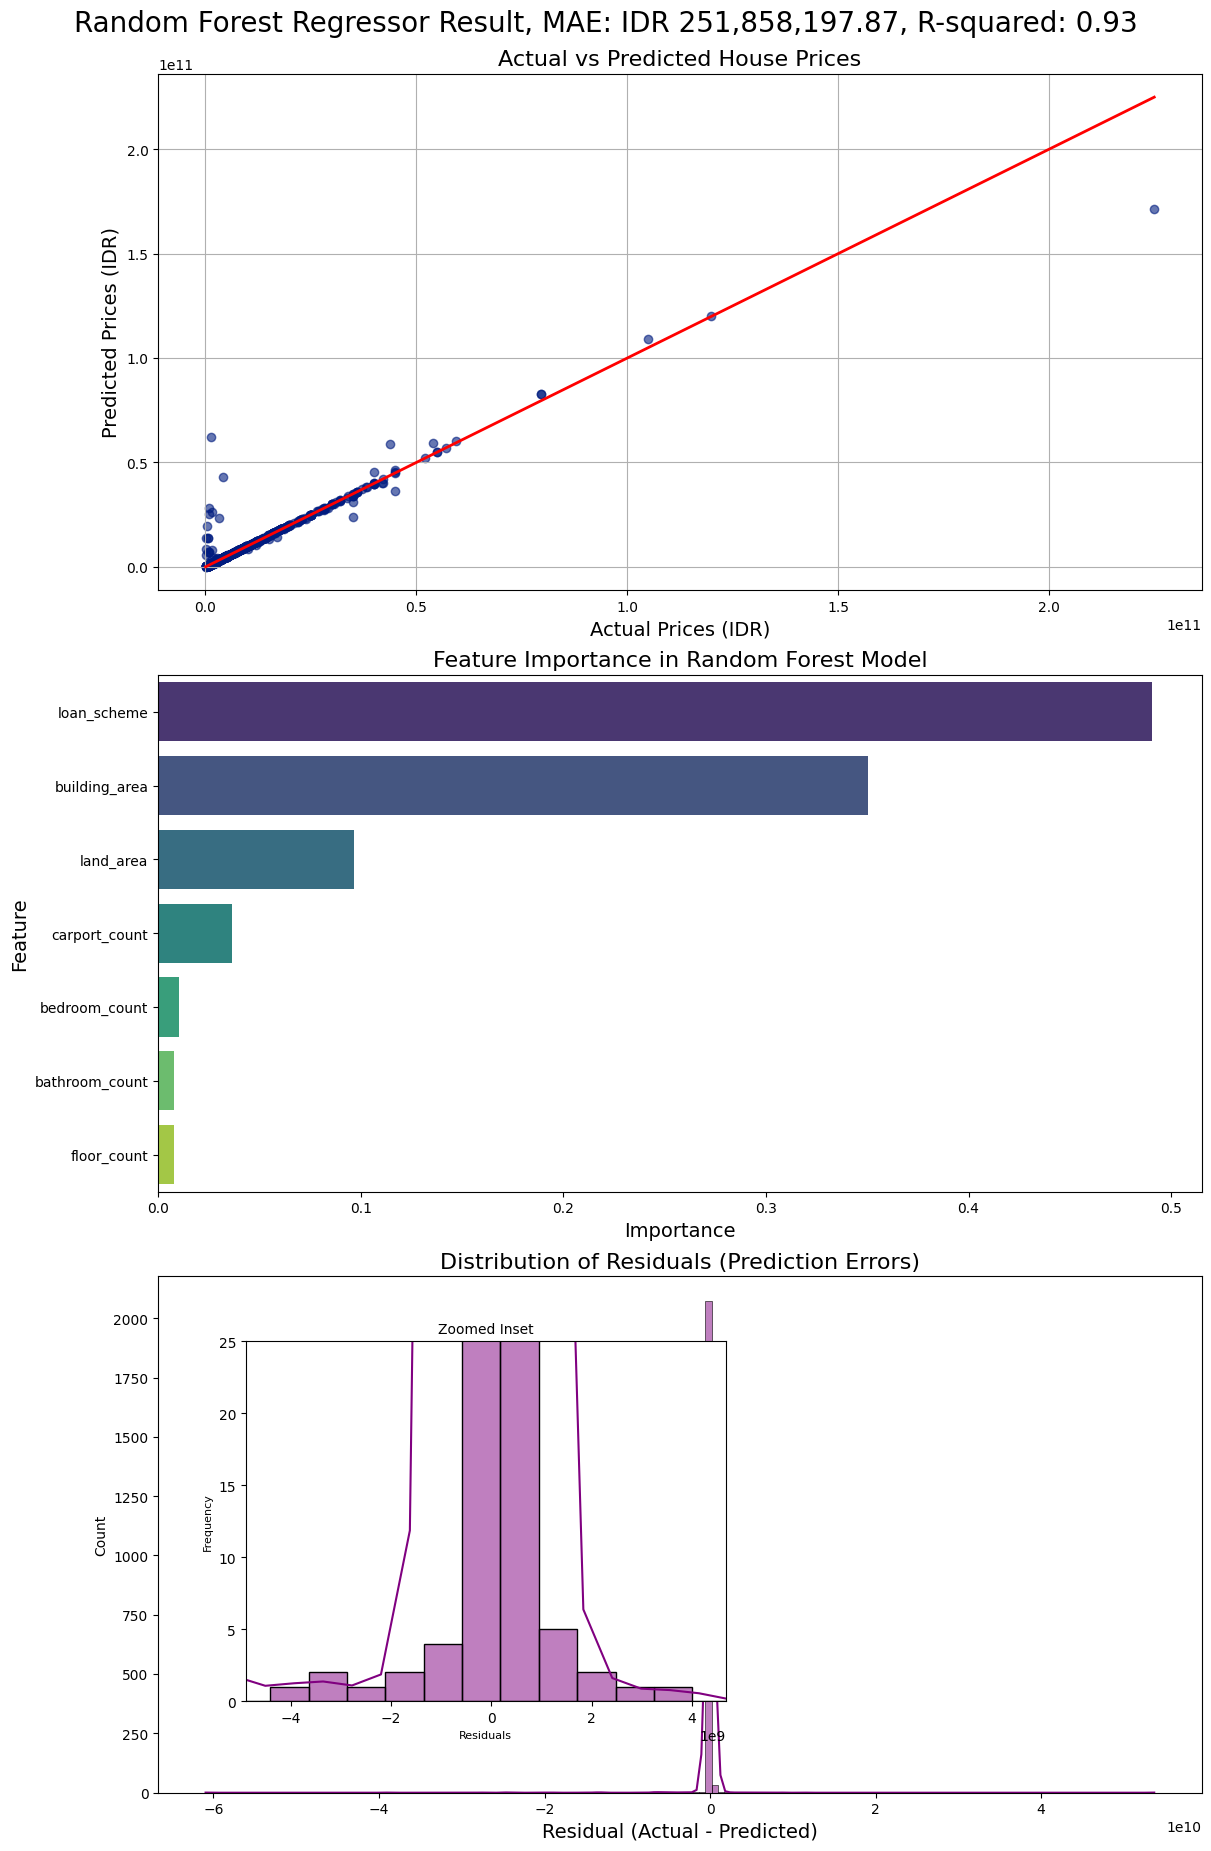

In [374]:
plot_model_results(y_test, y_pred_0, rf_model_0, X, rf0_mae, rf0_r2, 0)

In [375]:
residuals = y_test - y_pred_0
print(f"Random Forest Accuracy: {round(residuals[residuals == 0].count() / len(y_test)*100,2)}%")

Random Forest Accuracy: 2.7%


In [376]:
# Testing RF Model on our hypothetical client

rf0_df = df_test
rf0_pred = rf_model_0.predict(rf0_df)
formatted_prices = np.round(rf0_pred, 2)
print(f"Predicted full price is: IDR {formatted_prices[0]:,.2f}")

Predicted full price is: IDR 1,690,035,595.24


From our baseline model using the Random Forest Regressor with 1,000 decision trees, we obtained a Mean Absolute Error (MAE) value of IDR 251,858,197.87 and an R-squared value of 0.93.

- In general, a positive R-squared is almost a indicator, suggesting that the model does provide a proper regression fit. However the perfect value would have been 1, where all predicted and actual data match a straight line. This is visually evident in the very first graph, where a lot but not all data points are fitting the regression line.

- Looking at our MAE, we notice our model mispredicts prices by around IDR 251,858,197.87 (approximately 250 million) on average.
- The Random Forest Regressor also favors the loan scheme, followed by building area, and then land area. This feature selection is reasonable because most people consider these features in real life. It also demonstrates how effective Random Forest is at detecting low-correlated data.
- The residuals also show accurately predicted house prices (Actual - Predicted = 0). At least 58 out of 2,199 house prices (2.7%) are predicted correctly. There are also some extreme residuals where the model predicts a house price to be excessively high, above IDR 500 billion. The residuals also indicate that the model is more likely to provide higher price predictions.

**Moving on from Random Forest Regressor, Let's test neural network on our scenario**

In [377]:
# Sequential Neural Network with backpropagation (automatically involved)

model_0 = Sequential()

model_0.add(Dense(X_train.shape[1], activation='relu'))

model_0.add(Dense(16, activation='relu'))
model_0.add(Dropout(0.3))

model_0.add(Dense(32, activation='relu'))
model_0.add(Dropout(0.5))

model_0.add(Dense(1))

model_0.compile(optimizer='adam', loss=tf.keras.losses.MAE, metrics=['mae'])

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=8,
                               restore_best_weights=True)

In [379]:
model_0.fit(x=X_train,
          y=y_train,
          epochs=600,
          batch_size=128,
          validation_data=(X_test, y_test),
          callbacks=[early_stopping],
          verbose=0)

m0_history = model_0.history
m0_pred = model_0.predict(X_test)

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


It is best to see how the model learn pattern based on validity loss and mean absolute error. For this let's create a function to plot most of experimental model to find which one works best for our scenario.

In [380]:
# Plot the training history
def plot_training_history(history):
    # Extract metrics from the history object
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    mae = history.history.get('mae', None)
    val_mae = history.history.get('val_mae', None)

    epochs = range(1, len(loss) + 1)

    # Plot training & validation loss
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b-', label='Training loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # If MAE is available, plot it as well
    if mae and val_mae:
        plt.subplot(1, 2, 2)
        plt.plot(epochs, mae, 'b-', label='Training MAE')
        plt.plot(epochs, val_mae, 'r-', label='Validation MAE')
        plt.title('Training and Validation MAE')
        plt.xlabel('Epochs')
        plt.ylabel('Mean Absolute Error')
        plt.legend()

    plt.tight_layout()
    plt.show()

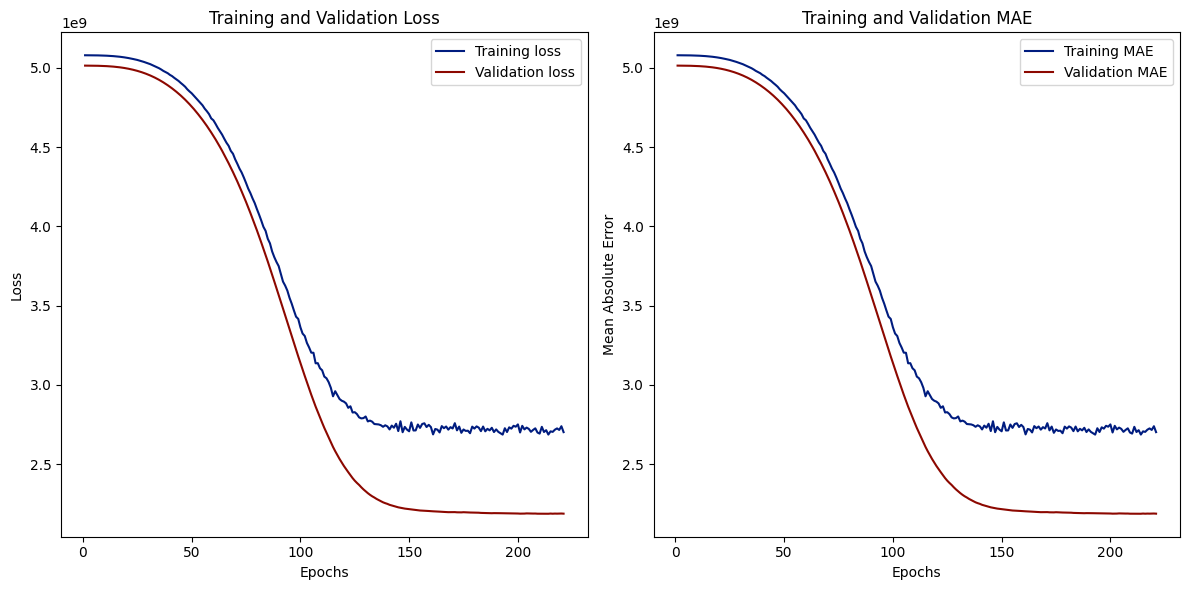

In [381]:
# Call the function to plot the training history
plot_training_history(m0_history)

In [382]:
# Neural Network model 0
m0_df = df_test
m0_pred = model_0.predict(m0_df)[0]
formatted_prices = np.round(m0_pred, 2)
print(f"Predicted full price is: IDR {formatted_prices[0]:,.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted full price is: IDR 1,039,099,584.00


Let's test if the features are scaled

In [383]:
X = df.drop(['price','nama_kecamatan'],axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [384]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [385]:
model_1 = Sequential()

model_1.add(Dense(X_train.shape[1], activation='relu'))

model_1.add(Dense(16, activation='relu'))
model_1.add(Dropout(0.3))

model_1.add(Dense(32, activation='relu'))
model_1.add(Dropout(0.5))

model_1.add(Dense(1))

model_1.compile(optimizer='adam', loss=tf.keras.losses.MAE, metrics=['mae'])

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=7,
                               restore_best_weights=True)

In [386]:
model_1.fit(x=X_train,
          y=y_train,
          epochs=1000,
          batch_size=128,
          validation_data=(X_test, y_test),
          callbacks=[early_stopping],
          verbose=0)

m1_history = model_1.history
m1_pred = model_1.predict(X_test)

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


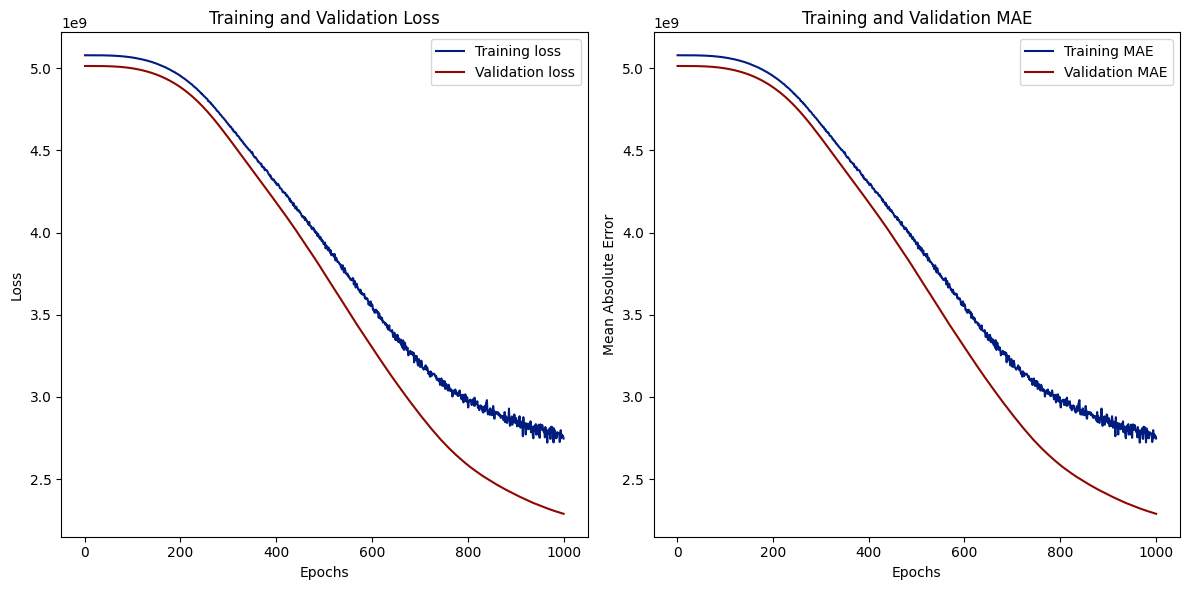

In [387]:
# Call the function to plot the training history
plot_training_history(m1_history)

In [388]:
# Neural Network model 1
df_m1 = scaler.transform(df_test)
m1_pred = model_1.predict(df_m1)[0]
formatted_prices = np.round(m1_pred, 2)
print(f"Predicted full price is: IDR {formatted_prices[0]:,.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted full price is: IDR 792,463,552.00


We have a slightly increase on predicting our client's house price from previous Neural Network Model. The key takeaway here is different preprocessing affect prediction models, we will compare the MAE from each model alongside its prediction on our hypothetical client later.

For futher feature engineering, we know some common correlation that does not involve actual price such as:

* Land-Building (land/building)
  - feature: whether the house has free land spaces
* Loan-Building (loan/building)
  - feature: how much we pay for the building
* Loan-Land (loan/land)
  - feature: how much we pay for the land
* Building-Floor (building/floor)
  - feature: average floor area on the whole building
* Bedroom-Bathroom-Carport-Building (Bedroom+Bathroom+Carport/Building)
  - feature: average rooms & carport size

In [389]:
def feature_engineering(df):
  df['land-building'] = df['land_area']/df['building_area']
  df['loan-building'] = df['loan_scheme']/df['building_area']
  df['loan-land'] = df['loan_scheme']/df['land_area']

  df['building-floor'] = df['building_area']/df['floor_count']
  df['suite-building'] = (df['bedroom_count']+df['bathroom_count']+df['carport_count'])/df['building_area']

  return df

feature_engineering(df)

price  loan_scheme  bedroom_count  bathroom_count  carport_count  \
0     2.100000e+09          7.0              3               2              2   
1     4.100000e+09         15.0              3               2              3   
2     3.300000e+09         12.0              5               2              1   
4     1.300000e+09          4.0             11               3              0   
5     3.600000e+09         13.0              5               3              1   
...            ...          ...            ...             ...            ...   
7653  1.100000e+09          4.0              4               2              0   
7654  1.300000e+09          4.0              3               2              0   
7655  1.100000e+09          4.0              3               1              0   
7656  6.750000e+08          2.0              2               1              0   
7658  8.900000e+08          3.0              2               1              0   

      land_area  building_area nama_kecamatan  floor_count  land-building  \
0         137.0          170.0          Andir          2.0       0.805882   
1         202.0          300.0          Andir          1.0       0.673333   
2         350.0          258.0          Andir          1.0       1.356589   
4         176.0          176.0          Andir          1.0       1.000000   
5         184.0          234.0          Andir          2.5       0.786325   
...         ...            ...            ...          ...            ...   
7653      128.0          100.0        Cinambo          2.0       1.280000   
7654       96.0          170.0        Cinambo          1.0       0.564706   
7655      122.0          148.0        Cinambo          1.0       0.824324   
7656       72.0           42.0        Cinambo          1.0       1.714286   
7658      126.0           70.0        Cinambo          1.0       1.800000   

      loan-building  loan-land  building-floor  suite-building  
0          0.041176   0.051095            85.0        0.041176  
1          0.050000   0.074257           300.0        0.026667  
2          0.046512   0.034286           258.0        0.031008  
4          0.022727   0.022727           176.0        0.079545  
5          0.055556   0.070652            93.6        0.038462  
...             ...        ...             ...             ...  
7653       0.040000   0.031250            50.0        0.060000  
7654       0.023529   0.041667           170.0        0.029412  
7655       0.027027   0.032787           148.0        0.027027  
7656       0.047619   0.027778            42.0        0.071429  
7658       0.042857   0.023810            70.0        0.042857  

[7163 rows x 14 columns]

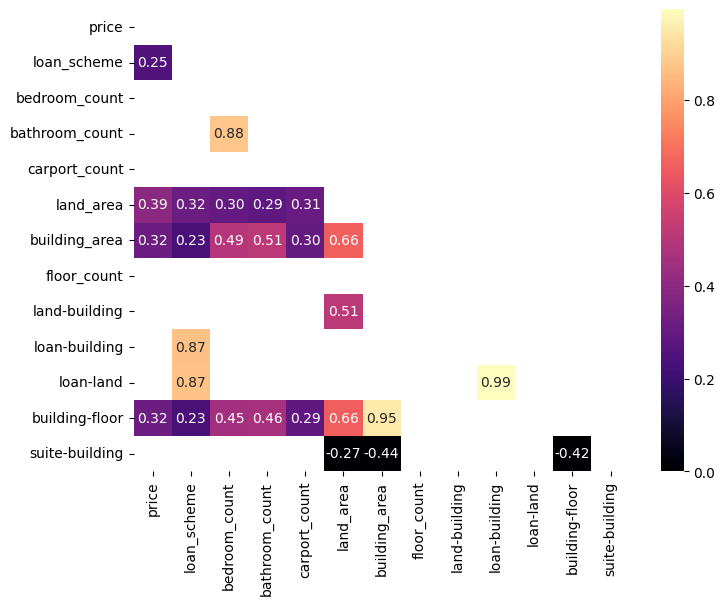

In [390]:
# Calculate the correlation matrix without categorical feature ('nama_kecamatan')
data = df.corr(numeric_only=True)

# Mask values between -0.2 and 0.2
masked_data = data.mask((data > -0.2) & (data < 0.2))

# Create a mask for the upper triangle (including the diagonal)
mask = np.triu(np.ones_like(masked_data, dtype=bool))

# Combine the mask with NaNs for values between -0.2 and 0.2
mask = mask | masked_data.isna()

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(masked_data, annot=True, fmt='.2f', cmap='magma', cbar=True, vmin=0,
            mask=mask)

plt.show()

Get dummies for district because some district are considered as higher class resulting higher price. This is an important feature we do not want to miss!

In [391]:
# Get Dummies
dummies = pd.get_dummies(df['nama_kecamatan'],drop_first=True,dtype=int)

# Concat new features
df = pd.concat([df,dummies],axis=1)
df = df.drop('nama_kecamatan',axis=1) # Drop existing District Column
df.head(15)

price  loan_scheme  bedroom_count  bathroom_count  carport_count  \
0   2.100000e+09          7.0              3               2              2   
1   4.100000e+09         15.0              3               2              3   
2   3.300000e+09         12.0              5               2              1   
4   1.300000e+09          4.0             11               3              0   
5   3.600000e+09         13.0              5               3              1   
6   1.170000e+09          4.0              2               1              1   
8   4.500000e+09         16.0              5               3              2   
9   2.100000e+09          7.0              3               2              2   
10  2.200000e+09          8.0              4               3              2   
11  1.400000e+09          5.0              2               2              1   
12  7.000000e+09         26.0              6               3              6   
13  3.600000e+09         13.0              5               5              1   
14  7.500000e+09         27.0              6               5              1   
15  5.800000e+09         21.0              4               3              7   
16  3.500000e+09         13.0              4               3              0   

    land_area  building_area  floor_count  land-building  loan-building  ...  \
0       137.0          170.0          2.0       0.805882       0.041176  ...   
1       202.0          300.0          1.0       0.673333       0.050000  ...   
2       350.0          258.0          1.0       1.356589       0.046512  ...   
4       176.0          176.0          1.0       1.000000       0.022727  ...   
5       184.0          234.0          2.5       0.786325       0.055556  ...   
6        65.0           45.0          1.0       1.444444       0.088889  ...   
8       404.0          250.0          1.0       1.616000       0.064000  ...   
9       137.0          170.0          1.0       0.805882       0.041176  ...   
10      172.0          220.0          1.0       0.781818       0.036364  ...   
11      137.0          160.0          1.0       0.856250       0.031250  ...   
12      188.0          260.0          1.0       0.723077       0.100000  ...   
13      184.0          250.0          1.0       0.736000       0.052000  ...   
14      268.0          700.0          3.0       0.382857       0.038571  ...   
15      400.0          400.0          1.0       1.000000       0.052500  ...   
16      222.0          196.0          1.0       1.132653       0.066327  ...   

    Kiaracondong  Lengkong  Mandalajati  Panyileukan  Rancasari  Regol  \
0              0         0            0            0          0      0   
1              0         0            0            0          0      0   
2              0         0            0            0          0      0   
4              0         0            0            0          0      0   
5              0         0            0            0          0      0   
6              0         0            0            0          0      0   
8              0         0            0            0          0      0   
9              0         0            0            0          0      0   
10             0         0            0            0          0      0   
11             0         0            0            0          0      0   
12             0         0            0            0          0      0   
13             0         0            0            0          0      0   
14             0         0            0            0          0      0   
15             0         0            0            0          0      0   
16             0         0            0            0          0      0   

    Sukajadi  Sukasari  Sumurbandung  Ujungberung  
0          0         0             0            0  
1          0         0             0            0  
2          0         0             0            0  
4          0         0             0            0  
5          0        

In [392]:
X = df.drop('price',axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [393]:
# Columns to transform (non-district features)
transformer = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), ['loan_scheme', 'bedroom_count', 'bathroom_count', 'carport_count',
                                      'land_area', 'building_area', 'floor_count', 'land-building',
                                      'loan-building', 'loan-land', 'building-floor', 'suite-building'])
    ],
    remainder='passthrough'  # Leave other features unchanged
)

# Apply the transformation
X_train = transformer.fit_transform(X_train)
X_test = transformer.transform(X_test)

In [394]:
# Convert back to a DataFrame for easier viewing (A view for selective standard scaler)
transformed_df = pd.DataFrame(X_test, columns=X.columns)
transformed_df

loan_scheme  bedroom_count  bathroom_count  carport_count  land_area  \
0       -0.274977      -0.556167       -0.296636      -0.784362  -0.317071   
1       -0.227707       0.142036       -0.031183       0.929522  -0.271860   
2       -0.117409       0.142036       -0.031183      -0.784362  -0.240778   
3        0.355295       0.607504        0.765175      -0.784362   0.813189   
4       -0.196193      -0.323433       -0.296636      -0.213068  -0.302942   
...           ...            ...             ...            ...        ...   
2144    -0.133166      -0.323433       -0.296636      -0.784362  -0.124926   
2145    -0.290734      -0.556167       -0.562088      -0.213068  -0.540297   
2146     0.181970       0.374770       -0.296636       0.358227   0.313049   
2147    -0.259220       0.142036       -0.296636      -0.784362  -0.449876   
2148     0.071672       0.374770        0.499722      -0.784362   1.160743   

      building_area  floor_count  land-building  loan-building  loan-land  \
0         -0.709291    -0.406038       0.651552      -0.082820  -0.103878   
1          0.002481    -0.406038      -0.593763      -0.093033  -0.087072   
2         -0.025989    -0.406038      -0.514087      -0.072536  -0.047117   
3          1.710736    -0.406038      -0.341320      -0.063509  -0.043856   
4         -0.301208    -0.406038      -0.350906      -0.078347  -0.070144   
...             ...          ...            ...            ...        ...   
2144      -0.097167    -0.406038      -0.220800      -0.072849  -0.067652   
2145      -0.922823    -0.406038       0.638034      -0.067966  -0.089316   
2146       0.049933    -0.406038       0.378495      -0.024293  -0.035054   
2147      -0.377131     1.928679      -0.634316      -0.091640  -0.081473   
2148       0.666803    -0.406038       0.706334      -0.066793  -0.089570   

      ...  Kiaracondong  Lengkong  Mandalajati  Panyileukan  Rancasari  Regol  \
0     ...           0.0       0.0          1.0          0.0        0.0    0.0   
1     ...           0.0       0.0          0.0          0.0        0.0    0.0   
2     ...           0.0       0.0          0.0          0.0        0.0    0.0   
3     ...           0.0       0.0          0.0          0.0        0.0    0.0   
4     ...           0.0       0.0          0.0          0.0        0.0    0.0   
...   ...           ...       ...          ...          ...        ...    ...   
2144  ...           0.0       0.0          0.0          0.0        0.0    0.0   
2145  ...           0.0       0.0          0.0          0.0        0.0    0.0   
2146  ...           0.0       0.0          0.0          0.0        0.0    1.0   
2147  ...           0.0       0.0          0.0          0.0        0.0    0.0   
2148  ...           1.0       0.0          0.0          0.0        0.0    0.0   

      Sukajadi  Sukasari  Sumurbandung  Ujungberung  
0          0.0       0.0           0.0          0.0  
1          0.0       0.0           0.0          0.0  
2          0.0       0.0           0.0          0.0  
3          0.0       0.0           0.0          0.0  
4          0.0       0.0           0.0          0.0  
...        ...       ...           ...          ...  
2144       0.0       0.0           0.0          0.0  
2145       0.0       0.0           0.0          0.0  
2146       0.0       0.0           0.0          0.0  
2147       0.0       0.0           0.0          0.0  
2148       0.0       0.0           0.0          0.0  

[2149 rows x 39 columns]

We selectively scale the features by not scaling categorical data, this is intended to hopefully find a hidden unknown features between the correlation of districts and numerical features. Hopefully, the model can understand that a district has an important role on deciding house price

In [395]:
model_2 = Sequential()

model_2.add(Dense(X_train.shape[1], activation='relu'))

model_2.add(Dense(64, activation='relu'))
model_2.add(Dropout(0.3))

model_2.add(Dense(128, activation='relu'))
model_2.add(Dropout(0.5))

model_2.add(Dense(256, activation='relu')) # We added another hidden layer for testing
model_2.add(Dropout(0.5))

model_2.add(Dense(1))

model_2.compile(optimizer='adam', loss=tf.keras.losses.MAE, metrics=['mae'])

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=7,
                               restore_best_weights=True)

In [396]:
model_2.fit(x=X_train,
          y=y_train,
          epochs=600,
          batch_size=128,
          validation_data=(X_test, y_test),
          callbacks=[early_stopping],
          verbose=0)

m2_history = model_2.history
m2_pred = model_2.predict(X_test)

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


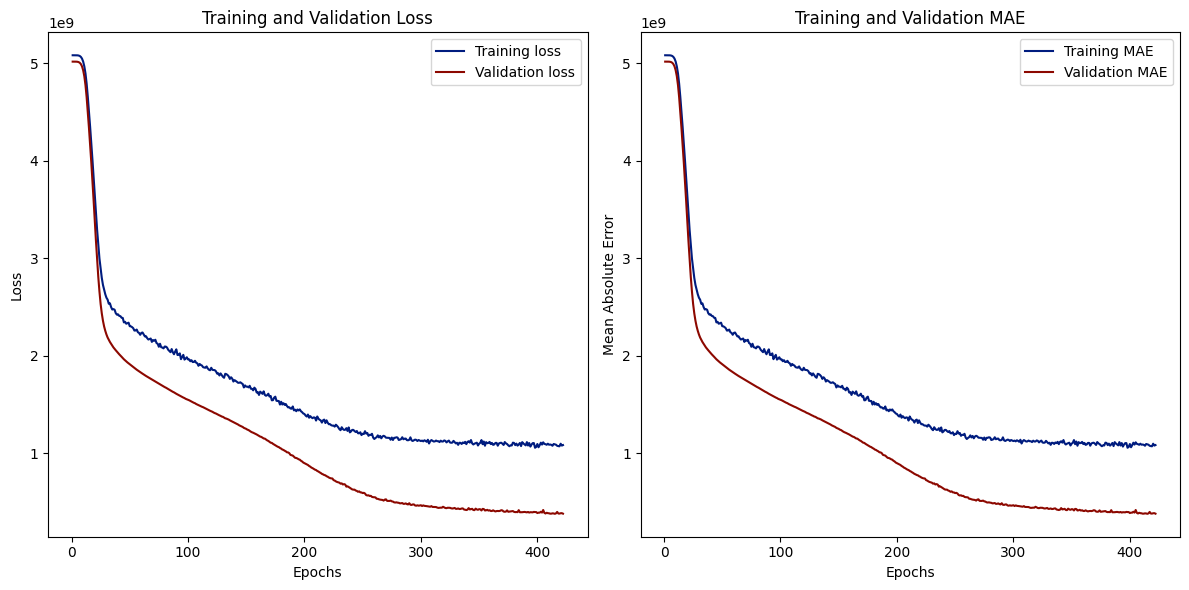

In [397]:
# Call the function to plot the training history
plot_training_history(m2_history)

We will also need to modify our hypothetical client dataset. since we already have the main input, we just need to focus on filling the desired districts

In [398]:
def fill_district(df, district_name):
    # Create a list of all district columns
    district_columns = ['Antapani', 'Arcamanik', 'Astanaanyar', 'Babakanciparay',
                        'Bandung Kidul', 'Bandung Kulon', 'Bandung Wetan', 'Batununggal',
                        'Bojongloa Kidul', 'Buah Batu', 'Cibeunying Kidul', 'Cibiru',
                        'Cicendo', 'Cidadap', 'Cinambo', 'Coblong', 'Gede Bage',
                        'Kiaracondong', 'Lengkong', 'Mandalajati', 'Panyileukan',
                        'Rancasari', 'Regol', 'Sukajadi', 'Sukasari', 'Sumurbandung',
                        'Ujungberung']

    # Reset all district columns to 0
    df[district_columns] = 0

    # If the district name is in the column list, set it to 1
    if district_name in df.columns:
        df[district_name] = 1
    else:
        print(f"{district_name} is not a valid district.")

    return df

# Define the columns of the test data, including district names
columns = ['loan_scheme', 'bedroom_count', 'bathroom_count', 'carport_count',
          'land_area', 'building_area', 'floor_count', 'land-building',
          'loan-building', 'loan-land', 'building-floor', 'suite-building',
          'Antapani', 'Arcamanik', 'Astanaanyar', 'Babakanciparay',
          'Bandung Kidul', 'Bandung Kulon', 'Bandung Wetan', 'Batununggal',
          'Bojongloa Kidul', 'Buah Batu', 'Cibeunying Kidul', 'Cibiru', 'Cicendo',
          'Cidadap', 'Cinambo', 'Coblong', 'Gede Bage', 'Kiaracondong',
          'Lengkong', 'Mandalajati', 'Panyileukan', 'Rancasari', 'Regol',
          'Sukajadi', 'Sukasari', 'Sumurbandung', 'Ujungberung']

# Re-Input House Data (make sure it's the same or adjust new input as well from here)
data = {
    'loan_scheme': [6],
    'bedroom_count': [3],
    'bathroom_count': [2],
    'carport_count': [1],
    'land_area': [72],
    'building_area': [45*1.5],
    'floor_count': [2]
}

# Add district columns and set them all to 0 initially
for district in columns[7:]:
    data[district] = [0]

# Create the DataFrame
df_test = pd.DataFrame(data)
feature_engineering(df_test)

# Now you can use the function to set the district
district_name = 'Buah Batu'  # Adjust the district here
df_test = fill_district(df_test, district_name)

# Check the test DataFrame
df_test

loan_scheme  bedroom_count  bathroom_count  carport_count  land_area  \
0            6              3               2              1         72   

   building_area  floor_count  land-building  loan-building  loan-land  ...  \
0           67.5            2       1.066667       0.088889   0.083333  ...   

   Kiaracondong  Lengkong  Mandalajati  Panyileukan  Rancasari  Regol  \
0             0         0            0            0          0      0   

   Sukajadi  Sukasari  Sumurbandung  Ujungberung  
0         0         0             0            0  

[1 rows x 39 columns]

In [399]:
# Neural Network model 2
m2_df = transformer.transform(df_test)
m2_pred = model_2.predict(m2_df)[0]
formatted_prices = np.round(m2_pred, 2)
print(f"Predicted full price is: IDR {formatted_prices[0]:,.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted full price is: IDR 1,133,550,336.00


we have a declining loss and Mean Absolute Error (MAE) on training process which is a good indicator, however we ended up with an increasing validation loss and validation MAE. This is a major issue that needs more feature engineering

Testing two-batch approaches by segmenting price dataset based on the price distribution. We know that price is ranged between e8 - e11, we could create a two batch with 1e10 as separator.

In [400]:
batch_1 = df.loc[df['price'] < 1e10]
batch_2 = df.loc[df['price'] >= 1e10]

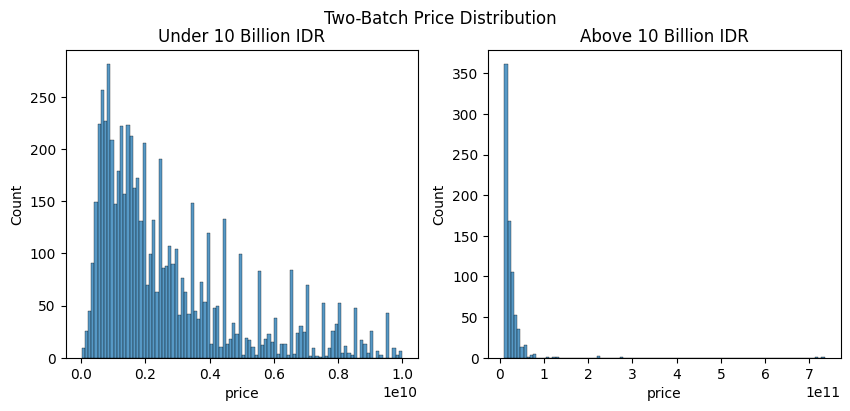

In [401]:
fig, axes = plt.subplots(1, 2,figsize=(10,4))
fig.suptitle('Two-Batch Price Distribution')

sns.histplot(ax=axes[0],data=batch_1['price'],bins=100)
axes[0].set_title('Under 10 Billion IDR')

sns.histplot(ax=axes[1],data=batch_2['price'],bins=100)
axes[1].set_title('Above 10 Billion IDR')

plt.show()

In [402]:
X = df.drop('price',axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Split the dataset based on price ranges
batch_1_indices = np.where(y_train < 1e10)[0]
batch_2_indices = np.where(y_train >= 1e10)[0]

# Use iloc to select rows based on the indices
X_train_batch_1, y_train_batch_1 = X_train.iloc[batch_1_indices], y_train.iloc[batch_1_indices]
X_train_batch_2, y_train_batch_2 = X_train.iloc[batch_2_indices], y_train.iloc[batch_2_indices]

In [403]:
# Creating Validation Test
X_test_batch_1 = batch_1.drop('price',axis=1)
y_test_batch_1 = batch_1['price']

X_test_batch_2 = batch_2.drop('price',axis=1)
y_test_batch_2 = batch_2['price']

# Fit transform each batch
X_train_batch_1 = transformer.fit_transform(X_train_batch_1)
X_test_batch_1 = transformer.transform(X_test_batch_1)

X_train_batch_2 = transformer.fit_transform(X_train_batch_2)
X_test_batch_2 = transformer.transform(X_test_batch_2)

# For general Data, re-fit & re-transform
X_train = transformer.fit_transform(X_train)
X_test = transformer.transform(X_test)

In [404]:
model_3 = Sequential()

model_3.add(Dense(X_train.shape[1], activation='relu'))

model_3.add(Dense(64, activation='relu'))
model_3.add(Dropout(0.3))

model_3.add(Dense(128, activation='relu'))
model_3.add(Dropout(0.5))

model_3.add(Dense(256, activation='relu'))
model_3.add(Dropout(0.5))

model_3.add(Dense(1))

model_3.compile(optimizer='adam', loss=tf.keras.losses.MAE, metrics=['mae'])

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True)

In [405]:
# We can actually switch both batches based on how we want the model to learn

# Train the model on batch 1
model_3.fit(X_train_batch_1,
            y_train_batch_1,
            epochs=500, batch_size=128,
            validation_data=(X_test_batch_1, y_test_batch_1),
            callbacks=[early_stopping],verbose=0)
m3h1 = model_3.history

# Train the model on batch 2
model_3.fit(X_train_batch_2,
            y_train_batch_2,
            epochs=100, batch_size=16,
            validation_data=(X_test_batch_2, y_test_batch_2),
            verbose=0)
m3h2 = model_3.history

model_3.fit(X_train,
            y_train,
            epochs=100, batch_size=256,
            validation_data=(X_test, y_test),
            verbose=0)

m3h3 = model_3.history
m3_pred = model_3.predict(X_test)

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


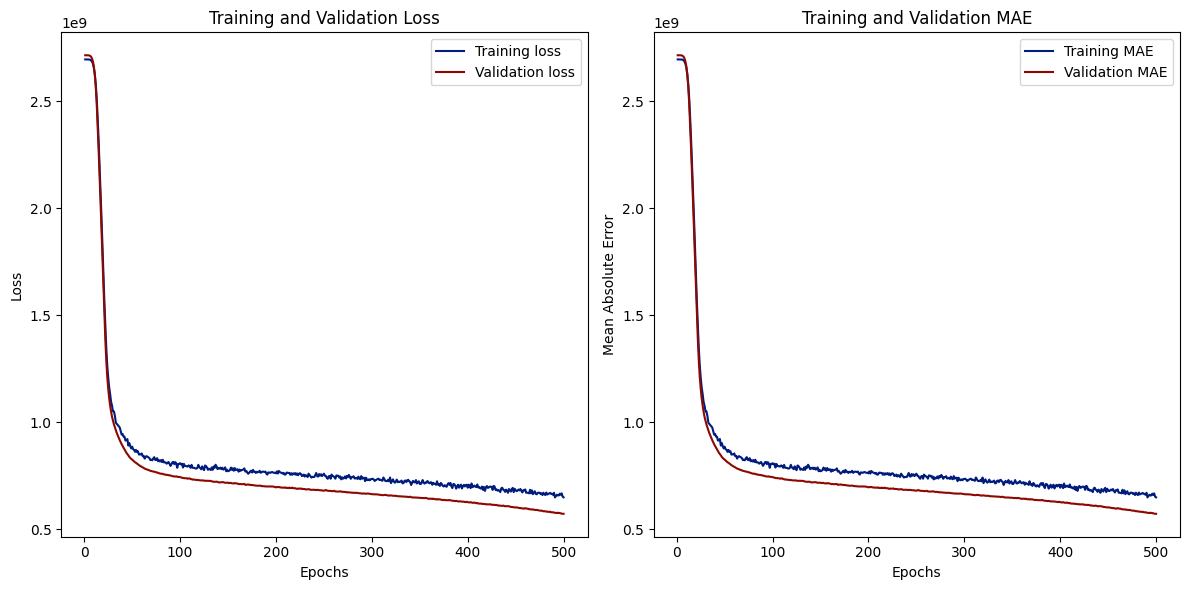

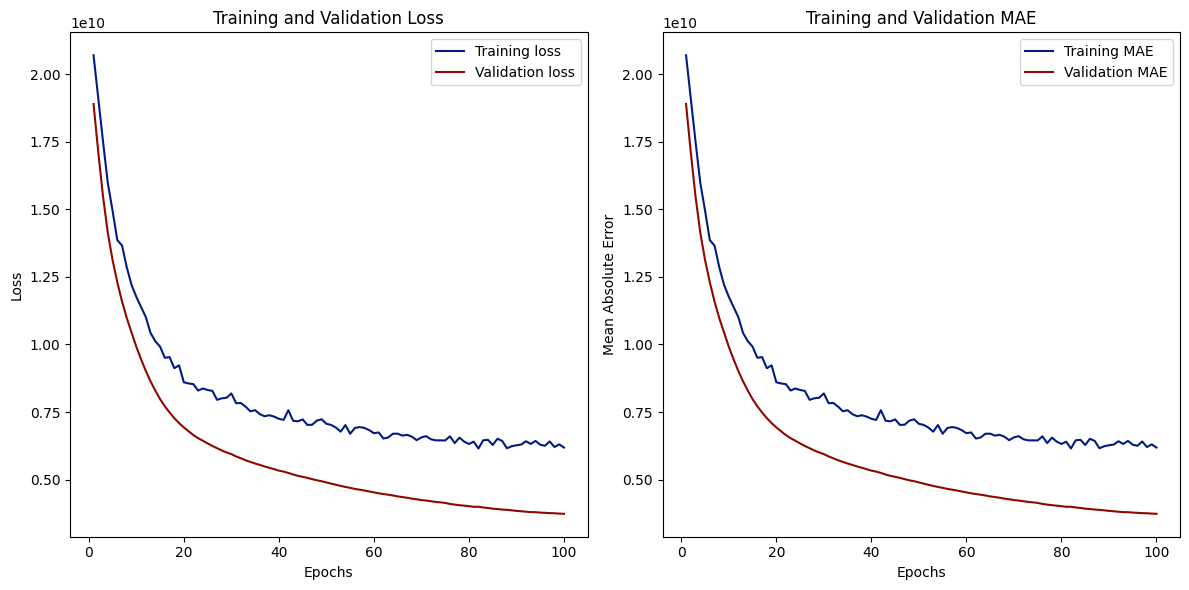

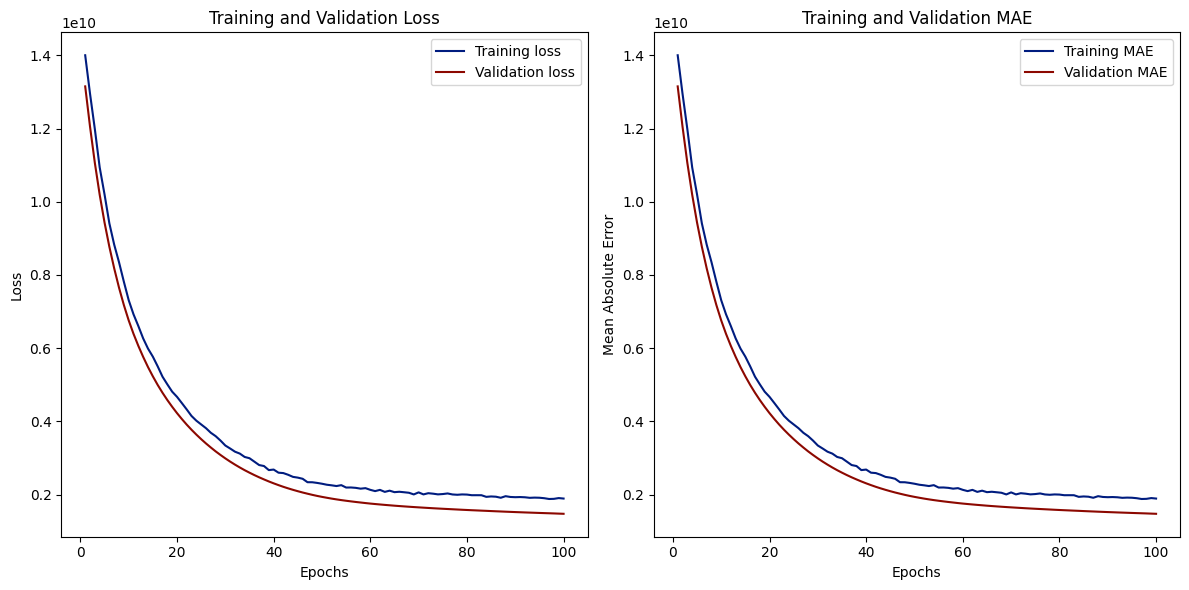

In [406]:
# Call the function to plot the training history
plot_training_history(m3h1)
plot_training_history(m3h2)
plot_training_history(m3h3)

In [407]:
# Neural Network model 3
m3_df = df_test
m3_pred = model_3.predict(m3_df)[0]
formatted_prices = np.round(m3_pred, 2)
print(f"Predicted full price is: IDR {formatted_prices[0]:,.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted full price is: IDR 153,199,591,424.00


In [408]:
# Function to concatenate multiple history objects
def combine_histories(*histories):
    combined_history = {}
    for key in histories[0].history.keys():  # iterate over keys like 'loss', 'val_loss', etc.
        combined_history[key] = []
        for history in histories:
            combined_history[key].extend(history.history[key])  # concatenate values for each metric
    return combined_history

# Combine the training histories
m3_history = combine_histories(m3h1, m3h2, m3h3)

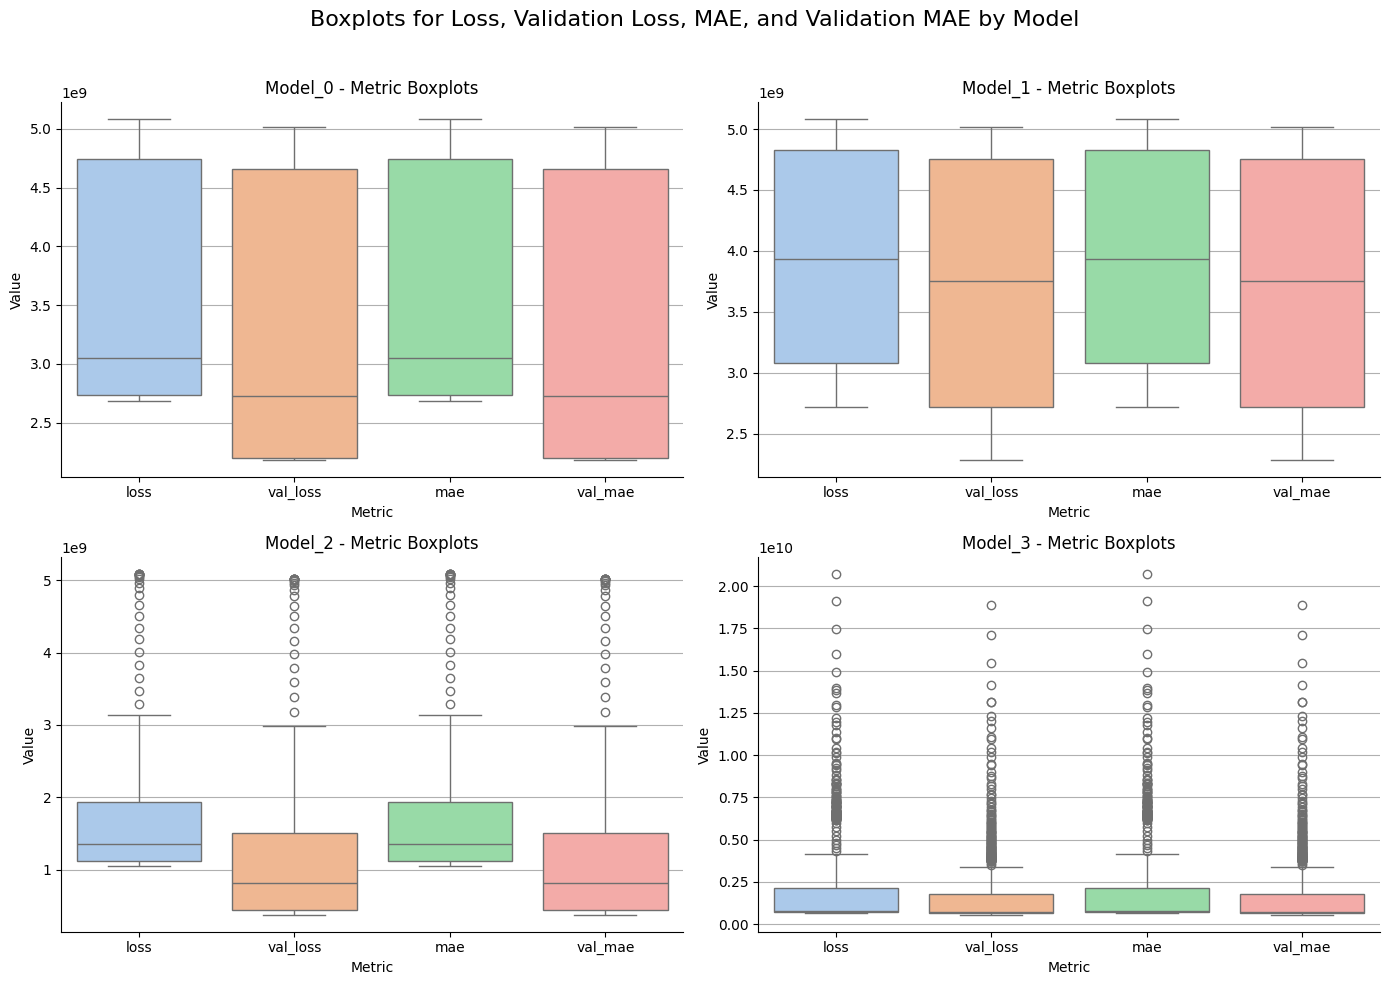

In [409]:
# Extract 'loss', 'val_loss', 'mae', and 'val_mae' from each model history
loss_0 = pd.DataFrame(m0_history.history)[['loss', 'val_loss', 'mae', 'val_mae']]
loss_1 = pd.DataFrame(m1_history.history)[['loss', 'val_loss', 'mae', 'val_mae']]
loss_2 = pd.DataFrame(m2_history.history)[['loss', 'val_loss', 'mae', 'val_mae']]
loss_3 = pd.DataFrame(m3_history)[['loss', 'val_loss', 'mae', 'val_mae']]

# Add a column to indicate which model each row belongs to
loss_0['Model'] = 'Model_0'
loss_1['Model'] = 'Model_1'
loss_2['Model'] = 'Model_2'
loss_3['Model'] = 'Model_3'

# Concatenate the DataFrames into a single DataFrame
combined_data = pd.concat([loss_0, loss_1, loss_2, loss_3])

# Melt the DataFrame so that 'loss', 'val_loss', 'mae', and 'val_mae' become a single column for plotting
melted_data = combined_data.melt(id_vars='Model', value_vars=['loss', 'val_loss', 'mae', 'val_mae'],
                                 var_name='Metric', value_name='Value')

# Create a 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()  # Flatten to easily index the subplots

# Define the models for iteration
models = ['Model_0', 'Model_1', 'Model_2', 'Model_3']

# Plot a separate boxplot for each model
for i, model in enumerate(models):
    sns.boxplot(x='Metric', y='Value', data=melted_data[melted_data['Model'] == model],
                ax=axes[i], palette='pastel')
    axes[i].set_title(f'{model} - Metric Boxplots')
    axes[i].set_ylabel('Value')
    axes[i].grid(axis='y', which='major')
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)

# Set the overall title
fig.suptitle('Boxplots for Loss, Validation Loss, MAE, and Validation MAE by Model', fontsize=16)

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the suptitle

# Show the plot
plt.show()

We have tested four sequential neural network model for predicting house prices and we can't seem to get any faster model with better MAE result than Random Forest Regressor without district. Let's test using district on Random Forest model

In [410]:
X = df.drop('price',axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [411]:
# Initialize the Random Forest Regressor model
rf_model_1 = RandomForestRegressor(n_estimators=1000, random_state=42)

# Train the model on the training data
rf_model_1.fit(X_train, y_train)

# Predict on the test data
y_pred_1 = rf_model_1.predict(X_test)

# Evaluate the model performance
rf1_mae = mean_absolute_error(y_test, y_pred_1)
rf1_r2 = r2_score(y_test, y_pred_1)

print(f"Mean Absolute Error (MAE): {rf1_mae}")
print(f"R-squared (R2): {rf1_r2}")

Mean Absolute Error (MAE): 384891226.1560908
R-squared (R2): 0.6462361027686623


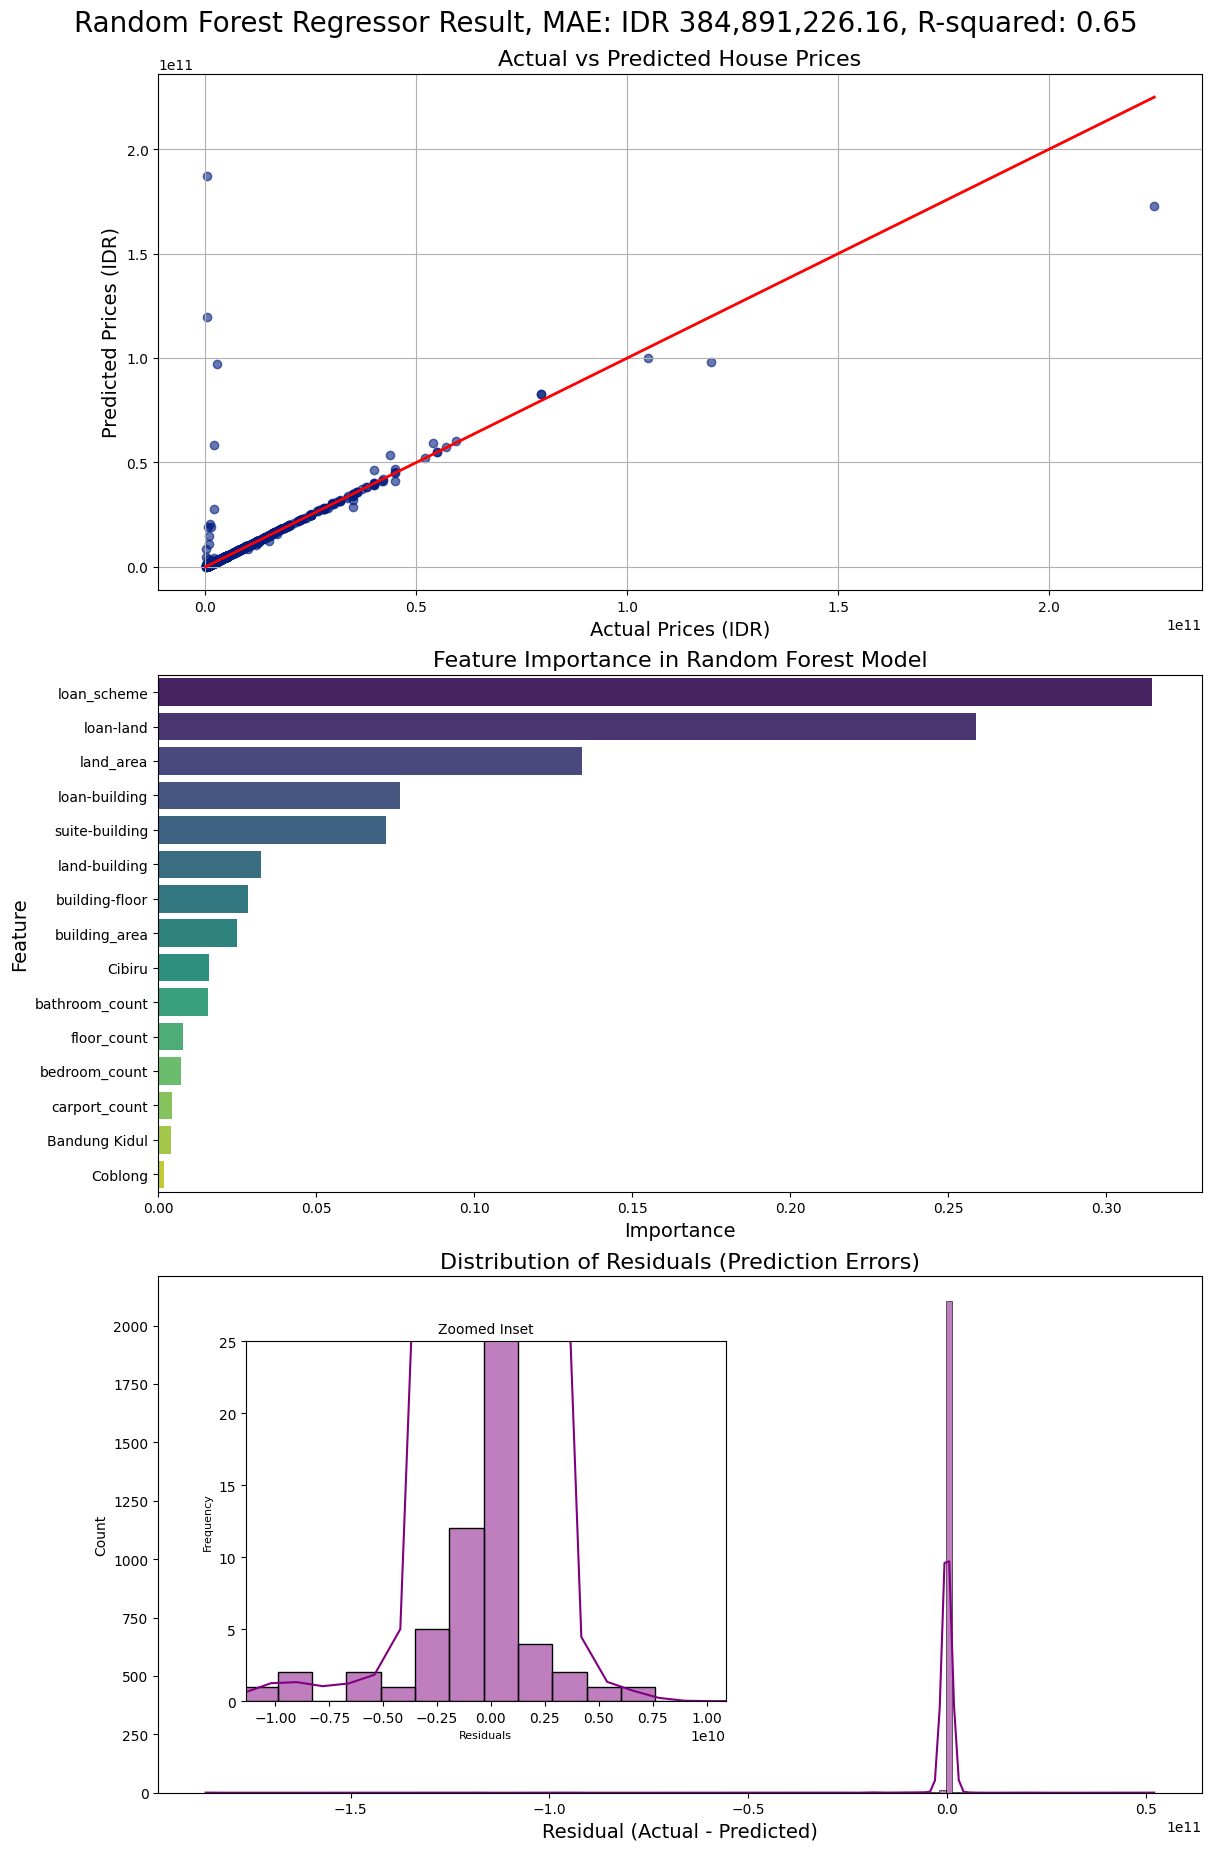

In [412]:
"""
Format for RF model plot function:

plot_model_results(y_test, y_pred,
                  RF model, df with no 'price',
                  mae, r2, important_threshold)
"""

plot_model_results(y_test, y_pred_1, rf_model_1, X, rf1_mae, rf1_r2, 0.001)

In [413]:
# Random Forest Regressor 1
rf1_pred = rf_model_1.predict(df_test)
formatted_prices = np.round(rf1_pred, 2)
print(f"Predicted full price is: IDR {formatted_prices[0]:,.2f}")

Predicted full price is: IDR 1,708,500,000.00


In [414]:
hypothetical = {'District': [False, False, False, True, True, True],
                'Model': ['Random Forest', 'Neural Network', 'Neural Network',
                          'Neural Network', 'Neural Network', 'Random Forest'],
                'Prediction (IDR)': [rf0_pred[0], m0_pred[0], m1_pred[0],
                               m2_pred[0], m3_pred[0], rf1_pred[0]],
                'MAE (IDR)':[rf0_mae,loss_0['mae'].iloc[-1],loss_1['mae'].iloc[-1],
                       loss_2['mae'].iloc[-1],loss_3['mae'].iloc[-1],rf1_mae]}

# Define formatting function
def format_currency(amount):
    return f'{amount:,.0f}'

df_hypo = pd.DataFrame(hypothetical)
df_hypo['Prediction (IDR)'] = df_hypo['Prediction (IDR)'].apply(format_currency)
df_hypo['MAE (IDR)'] = df_hypo['MAE (IDR)'].apply(format_currency)
df_hypo

District           Model Prediction (IDR)      MAE (IDR)
0     False   Random Forest    1,690,035,595    251,858,198
1     False  Neural Network    1,039,099,584  2,702,500,352
2     False  Neural Network      792,463,488  2,747,011,584
3      True  Neural Network    1,133,550,336  1,085,265,024
4      True  Neural Network  153,199,591,424  1,892,350,080
5      True   Random Forest    1,708,500,000    384,891,226

Based on our scenario, our customer who are currently looking for a minimalist house with at least 45 square meters of building area, with 1 carport, 3 bedrooms, 2 bathrooms, 2 floors and with possibly IDR 6 Million loan scheme gets various house price references. Obiviously with no specific district, they can set a baseline for a house price that meets their criteria. Furthermore, they can also adjust the price prediction with desired district.

Overall, the best model that might be used as a predictor is Random Forest Regressor on both with or without district. The model performs faster, has lower Mean Absolute Error and very robust towards outliers. Model including district has a lower R-Squared but that's tolerable since the model has to harvest hidden features from each district correlating to houses being listed from those area.

Neural Network models are performing poorly, with MAE values 10-20x greater than RF models. Neural network takes too long to train and does not out perform RF models based on predicting unseen data. As seen on Neural Network model_3, testing two batch training model might cause the model to 'forget' the previous learning process. It is proven on how the generalization learning process does not capture previous learning weights, making neural network less favoured on our house prediction goal. Neural Network models might not be applicable for our scenario on predicting house prices in Bandung. For further analysis, we will stick with Random Forest that includes districts as features.

We will conduct a confidence interval on this project for prediction analysis. There are several machine learning analysis methods such as Residual Analysis, Hypothesis Testing on Residuals, Prediction Intervals and so on. Confidence Interval analysis is a better way to quantify uncertainty in our predictions.

In [415]:
import scipy.stats as stats
from scipy.stats import skew
from scipy.stats import norm
from sklearn.utils import resample

# Skewness check
skewness = skew(df_analyze['price'])
print(f'Skewness of the data: {round(skewness,2)}')

Skewness of the data: 32.72


We know our data is positively skewed, both by Histogram Plot and skewness value. In positively skewed data:

* The distribution has a longer right tail, making the data more concentrated in lower values.
* A standard confidence interval based on the normal distribution may not accurately capture the true distribution of the data, especially in the presence of outliers.

**Bootstrapping Confidence Intervals**

Bootstrapping is a resampling technique that repeatedly samples from the data with replacement to estimate the sampling distribution of a statistic. It doesn't rely on the assumption of normality.

In [416]:
# Function to bootstrap confidence intervals
def bootstrap_ci(data, confidence=0.90, n_iterations=1000): # Set default confidence 90%
    bootstrapped_means = []

    # Resampling process
    for _ in range(n_iterations):
        sample = resample(data)  # Resample the data with replacement
        bootstrapped_means.append(np.mean(sample))  # Compute the mean for each sample

    # Calculate percentiles for the CI
    lower_bound = np.percentile(bootstrapped_means, (1 - confidence) / 2 * 100)
    upper_bound = np.percentile(bootstrapped_means, (1 + confidence) / 2 * 100)

    return np.mean(bootstrapped_means), lower_bound, upper_bound

# Example usage
mean_val, ci_lower, ci_upper = bootstrap_ci(df_analyze['price'], confidence= 0.99)
print(f'Bootstrapped Mean: {format_currency(mean_val)}')
print(f'90% Confidence Interval: [{format_currency(ci_lower)}, {format_currency(ci_upper)}]')

Bootstrapped Mean: 5,053,002,596
90% Confidence Interval: [4,666,808,540, 5,498,447,052]


In [417]:
# We can also provide a Log-transform method

log_data = np.log(df_analyze['price'] + 1)  # Apply log transformation (shift data to avoid log(0))

# Calculate mean and standard error on log-transformed data
log_mean = np.mean(log_data)
log_se = np.std(log_data) / np.sqrt(len(log_data))

# Confidence interval on log-transformed data
z = 1.645  # For 90% CI
log_ci_lower = log_mean - z * log_se
log_ci_upper = log_mean + z * log_se

# Transform back to original scale
ci_lower = np.exp(log_ci_lower) - 1
ci_upper = np.exp(log_ci_upper) - 1

print(f'Log-Transformed 90% Confidence Interval: [{format_currency(ci_lower)}, {format_currency(ci_upper)}]')

Log-Transformed 90% Confidence Interval: [2,463,489,120, 2,568,966,889]


In [418]:
# Testing quantiles for Confidence Interval
confidence = 90

lower_q = (100 - confidence)/2
upper_q = 100 - (100 - confidence)/2

ci_lower = np.percentile(df_analyze['price'], lower_q)
ci_upper = np.percentile(df_analyze['price'], upper_q)

print(f'{confidence}% Confidence Interval (Quantiles): [{format_currency(ci_lower)}, {format_currency(ci_upper)}]')

90% Confidence Interval (Quantiles): [540,000,000, 18,000,000,000]


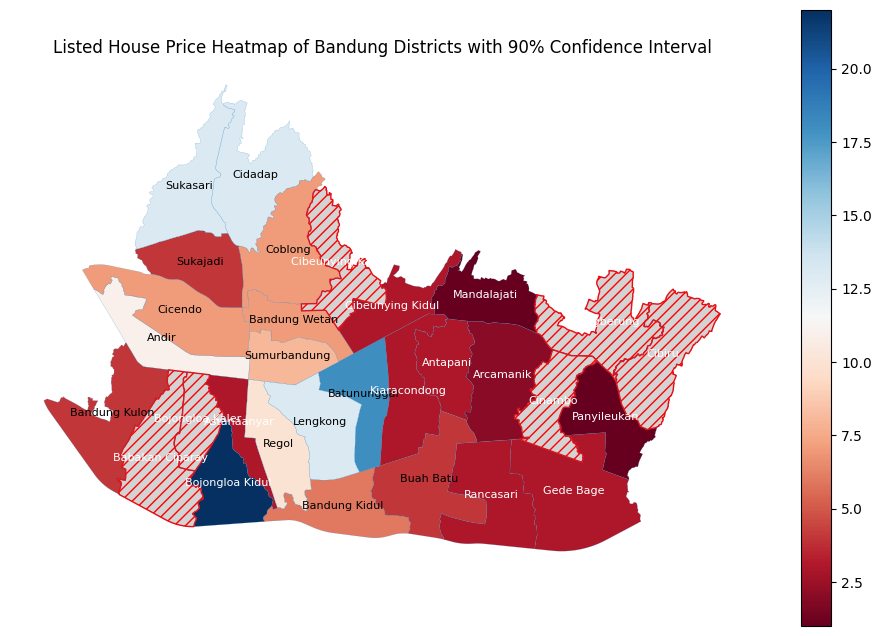

In [419]:
# Bootstrapping Confidence Interval with districts

confidence = 0.90

mean_val, ci_lower, ci_upper = bootstrap_ci(df_analyze['price'], confidence=confidence)

df_90ci = df_analyze.query('`price` >= @ci_lower & `price` < @ci_upper')

df_90ci_count = df_90ci.groupby('nama_kecamatan')['price'].count()

df_90ci_count = districts.join(df_90ci_count, on="nama_kecamatan")

plot_district_heatmap(districts, df_90ci_count,
                      column='price',
                      title=f'Listed House Price Heatmap of Bandung Districts with {int(confidence*100)}% Confidence Interval')

Based on the graph we plot, we can be 90% sure that houses being listed online are between IDR 4.7 Billion and IDR 5.5 Billion. This range seems tight for house prices in a city, however it shows how competitive the house market based on online listings. We can also see houses listed online based on their districts, Bojongloa Kidul is most likely be an option in 90% Confidence interval. We also remove three districts such as Cinambo, Cibiru and Ujungberung. These districts most likely fall in the 10% Interval.

In [420]:
# Calculate confidence intervals for each district (default confidence = .90)
district_conf_intervals = df_analyze.groupby('nama_kecamatan')['price'].apply(bootstrap_ci)

# Create separate columns for mean, lower, and upper bounds of confidence intervals
df_intervals = pd.DataFrame(district_conf_intervals.tolist(),
                            index=district_conf_intervals.index,
                            columns=['mean', 'ci_lower', 'ci_upper'])

# Merge the intervals back with the original DataFrame
df_district_ci90 = df_intervals.reset_index()
df_district_ci90['range'] = df_district_ci90['ci_upper'] - df_district_ci90['ci_lower']

# Descending based on the mean
df_district_ci90.sort_values('mean',ascending=False).head()

nama_kecamatan          mean      ci_lower      ci_upper         range
7   Bandung Wetan  1.764892e+10  1.632402e+10  1.916709e+10  2.843065e+09
16        Coblong  1.558589e+10  1.242368e+10  1.904521e+10  6.621533e+09
26   Sumurbandung  1.405393e+10  1.298257e+10  1.518878e+10  2.206202e+09
13        Cicendo  8.920456e+09  7.328757e+09  1.081495e+10  3.486193e+09
14        Cidadap  8.255596e+09  7.461520e+09  9.087587e+09  1.626066e+09

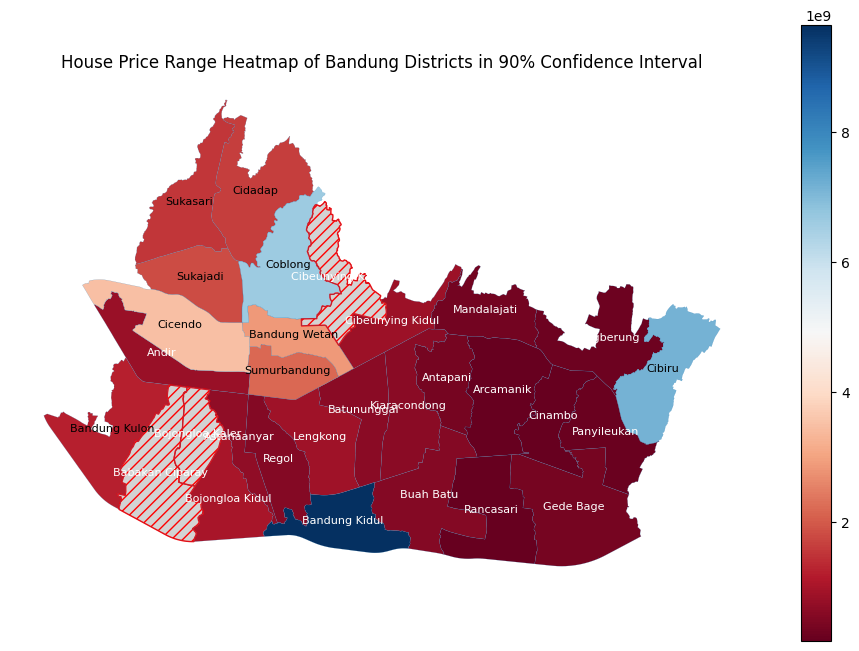

In [421]:
# Using merge for a more controlled join
df_ci90_plot = pd.merge(districts, df_district_ci90, on="nama_kecamatan", how="left")

# Plot the heatmap after joining
plot_district_heatmap(districts, df_ci90_plot,
                      column='range',
                      title='House Price Range Heatmap of Bandung Districts in 90% Confidence Interval')

Some districts has higher interval range than others districts. This shows how some districts are a little loose on pricing with 90% confidence interval. Some districts like Coblong, Cibiru, and Bandung Kidul might be a good for negotiations target since the prices are not as strict as other districts like Arcamanik, Rancasari and several East to South East Bandung districts

In [422]:
df_hypo

District           Model Prediction (IDR)      MAE (IDR)
0     False   Random Forest    1,690,035,595    251,858,198
1     False  Neural Network    1,039,099,584  2,702,500,352
2     False  Neural Network      792,463,488  2,747,011,584
3      True  Neural Network    1,133,550,336  1,085,265,024
4      True  Neural Network  153,199,591,424  1,892,350,080
5      True   Random Forest    1,708,500,000    384,891,226

In [423]:
df_district_ci90[df_district_ci90['nama_kecamatan'] == "Buah Batu"]

nama_kecamatan          mean      ci_lower      ci_upper         range
10      Buah Batu  2.658526e+09  2.389867e+09  2.948324e+09  5.584570e+08

Looking back at out hypothetical client, we can see that the best model with district is Random Forest and its prediction is below ci_lower for 90% Confidence Interval. It might be hard for our client to find their dream house that matches his criteria based on our price prediction model. However the prices does not look too far from ci_lower (IDR 600 Million), there might be some available houses with slightly different features.

Our Random Forest Model with district has similar Confidence Interval Range to our y_test. Since our y_test CI range also close to overall dataset, we can say that RF Model CI range is also similar to overall dataset CI range. Our RF Model has slightly higher lower and upper bound (around IDR 2-3 Billion gap). This is a good indicator that our model can be use to predict house prices **with several cautions**.

In [424]:
def CI_plot(data,confidence,lower_x_lim=-8e9,upper_x_lim=5e10):
    # 1. Bootstrapped Confidence Interval
    mean_val, boot_ci_lower, boot_ci_upper = bootstrap_ci(data, confidence=confidence)

    # 2. Log-Transformed Confidence Interval
    log_data = np.log(data + 1)  # Shift data to avoid log(0)
    log_mean = np.mean(log_data)
    log_se = np.std(log_data) / np.sqrt(len(log_data))
    z = norm.ppf((1 + confidence) / 2)
    log_ci_lower = log_mean - z * log_se
    log_ci_upper = log_mean + z * log_se
    log_ci_lower_original = np.exp(log_ci_lower) - 1  # Convert back to original scale
    log_ci_upper_original = np.exp(log_ci_upper) - 1

    # 3. Quantile-based Confidence Interval
    lower_q = (100 - confidence)/2
    upper_q = 100 - (100 - confidence)/2

    quant_ci_lower = np.percentile(data, lower_q)
    quant_ci_upper = np.percentile(data, upper_q)

    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # Define the x-axis limit
    x_limits = (lower_x_lim,upper_x_lim)  # Example limits based on your data

    # Set the x-axis limits for all subplots
    for ax in axes:
        ax.set_xlim(x_limits)

    # KDE Plot with Bootstrapped CI
    sns.kdeplot(data, ax=axes[0], color='blue', shade=True)
    axes[0].axvline(mean_val, color='blue', linestyle='--', label=f'Bootstrapped Mean: {format_currency(mean_val)}')
    axes[0].axvspan(boot_ci_lower, boot_ci_upper, color='blue', alpha=0.3,
                    label=f'{int(confidence*100)}% CI: [{format_currency(boot_ci_lower)},{format_currency(boot_ci_upper)}]')
    axes[0].set_title('Bootstrapped Confidence Interval')
    axes[0].set_xlabel('Data Values')
    axes[0].set_ylabel('Density')
    axes[0].legend()

    # KDE Plot with Log-Transformed CI
    sns.kdeplot(data, ax=axes[1], color='green', shade=True)
    axes[1].axvspan(log_ci_lower_original, log_ci_upper_original, color='green', alpha=0.3,
                    label=f'{int(confidence*100)} Log-Transformed CI:\n[{format_currency(log_ci_lower_original)}, {format_currency(log_ci_upper_original)}]')
    axes[1].set_title('Log-Transformed Confidence Interval')
    axes[1].set_xlabel('Data Values')
    axes[1].set_ylabel('Density')
    axes[1].legend()

    # KDE Plot with Quantile-based CI
    sns.kdeplot(data, ax=axes[2], color='orange', shade=True)
    axes[2].axvspan(quant_ci_lower, quant_ci_upper, color='orange', alpha=0.3,
                    label=f'{int(confidence*100)}% Quantile-based CI:\n[{format_currency(quant_ci_lower)}, {format_currency(quant_ci_upper)}]')
    axes[2].set_title('Quantile-based Confidence Interval')
    axes[2].set_xlabel('Data Values')
    axes[2].set_ylabel('Density')
    axes[2].legend()

    plt.tight_layout()
    plt.show()

Parametric methods based on normality assumptions can lead to misleading results, non-parametric methods like bootstrapping or using log-transformations might provide more reliable estimates. Always visualize and understand the distribution!

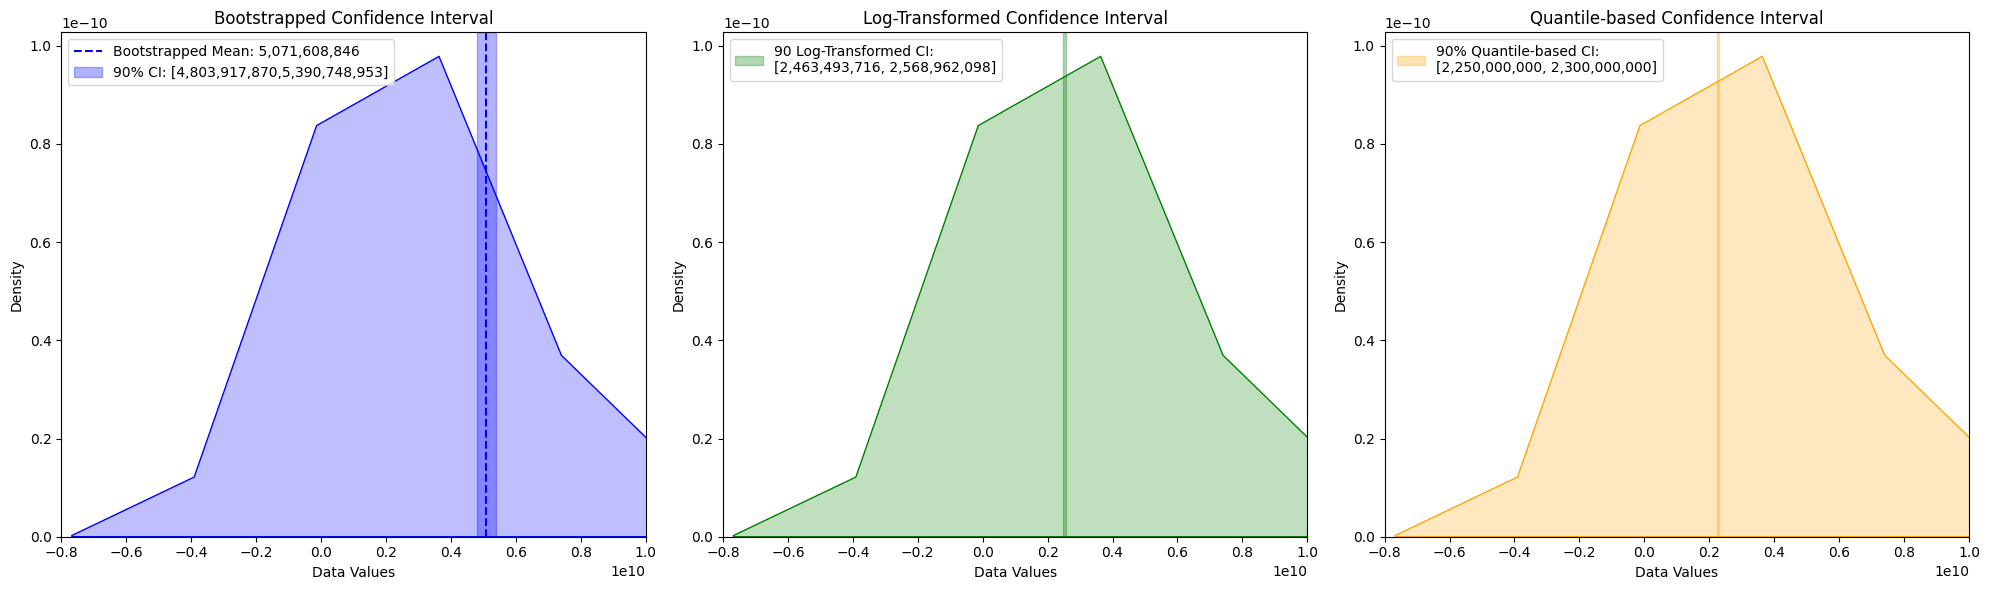

In [425]:
data = df_analyze['price']
confidence = .90

CI_plot(data, confidence, upper_x_lim=1e10)

Using Bootstrapped Confidence Interval benefits us with non-parametic statistical analysis, by removing normality assumptions that tends to shift the true mean and provide an easier construction of confidence interval from the resampling distribution. Bootstrapped CI also has the widest wiggle room (lower bound and upper bound range) for price speculation. Let's see how this method work on our Random Forest model

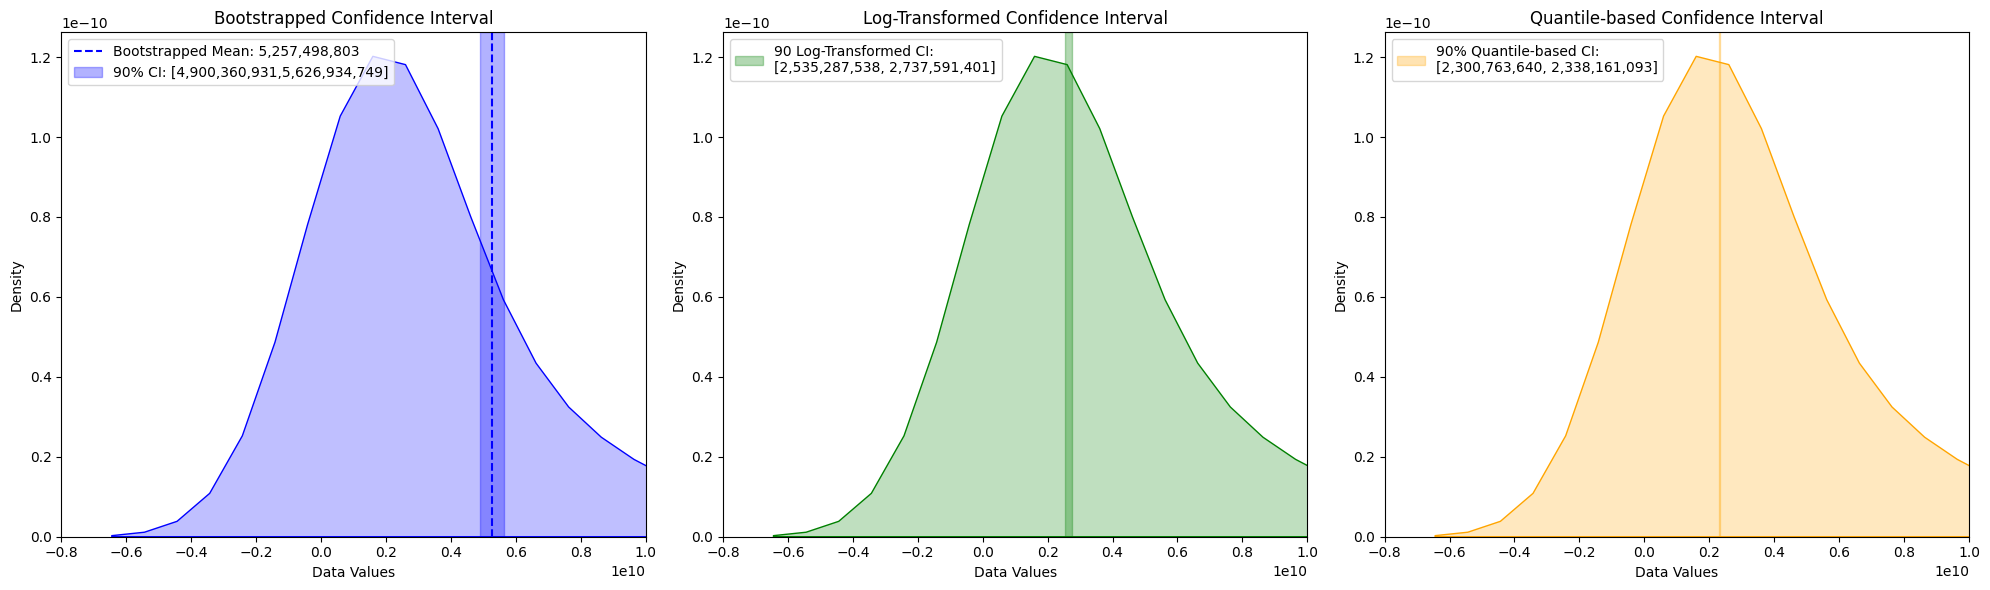

In [426]:
# Let's test three CI method on our RF model
data = y_pred_1
confidence = .90

CI_plot(data,confidence,upper_x_lim=1e10)

Confidence interval on predicted house price using Random Forest model has almost similar bound to our sample data, higher bound around IDR 200-300 Million similar to its MAE. This means that our model is reliable and applicable if our client's risk tolerance is around the MAE values.

# Summary and Key Takeaways

**To summarize the work we did on this project, here's a chronological list of actions:**

1. Read the main dataset to identify general features.
2. Set targets based on the availability of the main data.
3. Cleaned the main data and extracted hidden features from descriptions (house_name).
4. Imported GeoJSON data for district plotting using geopandas.
5. Created simple plots to get a general understanding of the main data's availability.
6. Introduced domain knowledge regarding district characteristics.
7. Filled in missing data using a similar method from web scraping.
8. Created additional plots to identify unusable data or illogical values.
9. Selected usable features for predictions and filled NaN rows based on hidden features in the description.
10. Prepared prediction models, exploring both Machine Learning and Neural Networks.
11. Tested the Random Forest Regressor as a baseline model.
12. Tested a Sequential Neural Network to identify areas for improvement.
13. Performed feature engineering to highlight specific features during testing.
14. Conducted two batches of learning processes on the large dataset.
15. Retested the engineered features using the Random Forest Regressor.
16. Interpreted the models through various visualizations.
17. Performed further analysis using confidence intervals.
18. Bootstrapped Confidence Interval has the biggest interval (wiggle room for speculation)

**Key Takeaways**

1. Data Availability
We have unavailable districts:
* cibeunying kaler
* babakan ciparay
* bojongloa kaler
  
  These districts should not be an option for our hypothetical client to find houses using our dataset, this could be improved by scrapping or even asking some other companies for data.

2. Prediction Model
The best model used in this project is **Random Forest Regressor** both with and without districts. Our model has the smallest MAE, fastest learning process, and closer on matching 90% Confidence Interval.

3. Result analysis
Predictive model are meant for speculation, using Confidence Interval method helps setting the realism of our speculation both on the data and the model. Our best model has a slightly higher mean, lower bound and higher bound confidence interval than our true data. Predicting an unseen data or house prices using this model can be done with precaution.

4. Cautions needed based on this projects:
  * **Predicted price is not exact and might shift according to the MAE values.**
  * **Actual Price Distribution is positively skewed, setting a limit on price range might increase accuracy on predictive model**
  * **Confidence Interval Analysis on skew data requires careful handling.**
  * **Always visualize and understand the distribution before calculating Confidence Interval, and consider the median or quantile-based methods for robust results in highly skewed data.**

